In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann
from scipy.constants import e
path = "C:/Users/Thomas/Laboratorio_Intermedio/Hall Effect/Data/"

> ## Bitácora - Experimento del Efecto Hall

**Hecho por:** Simón Felipe Jimenez Botero & Thomas Andrade Hernández.

---

En el presente documento se encuentran desglozados los resultados de las mediciones asociadas al montaje experimental del Efecto Hall clásico. A lo largo de este código se podrán observar los resultados de cada medición, gráficas e información relacionada a cada una de las regresiones que se realicen, sumado a una breve explicación previa acerca de aquello que estamos haciendo, cómo lo estamos haciendo y alguna que otra cosa a tener presente para su replicación.

---

> **Montaje Experimental:**

Las mediciones que fueron realizadas a lo largo de las horas de laboratorio son derivadas del siguiente montaje experimental:

**Imagen del montaje entero:**

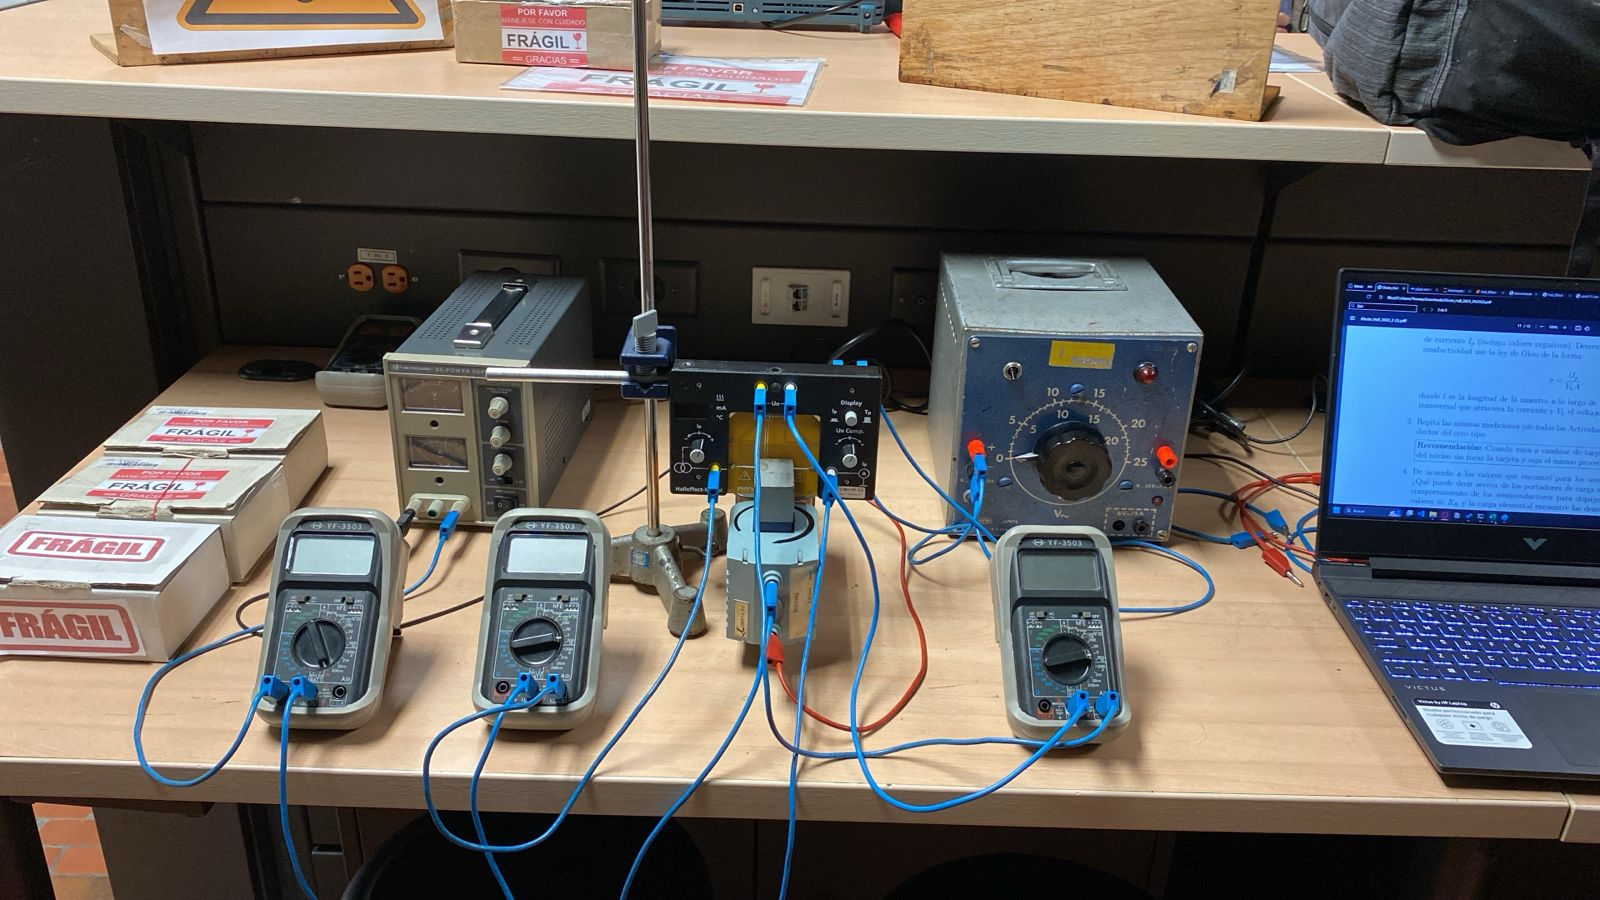

**Imagen de la fuente AC:**

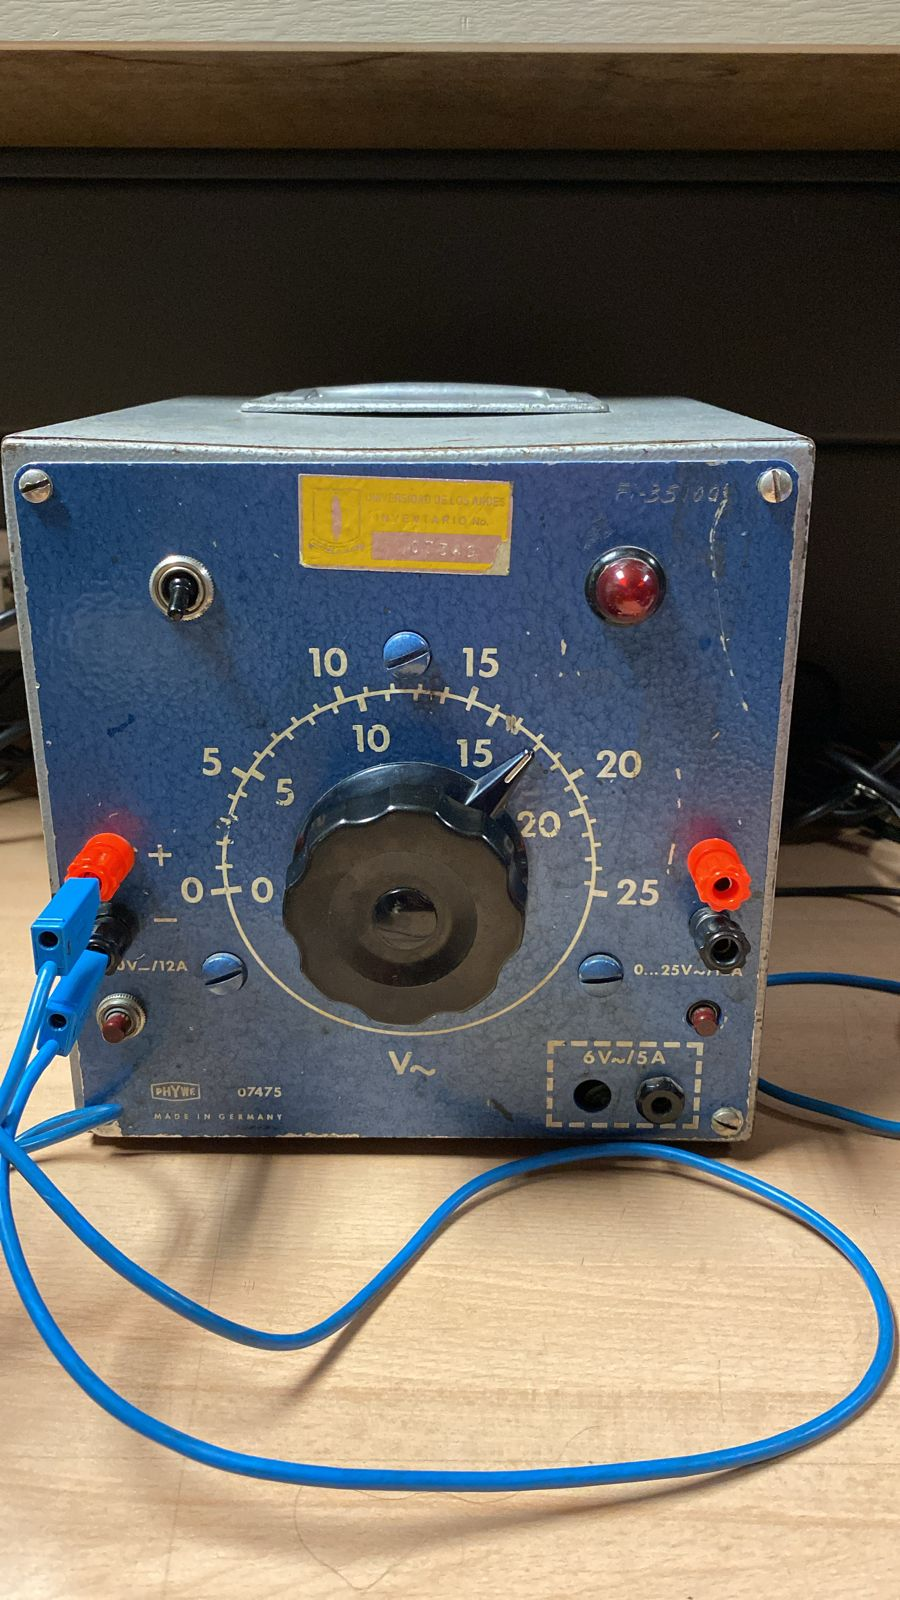

**Imagen de la fuente DC:**

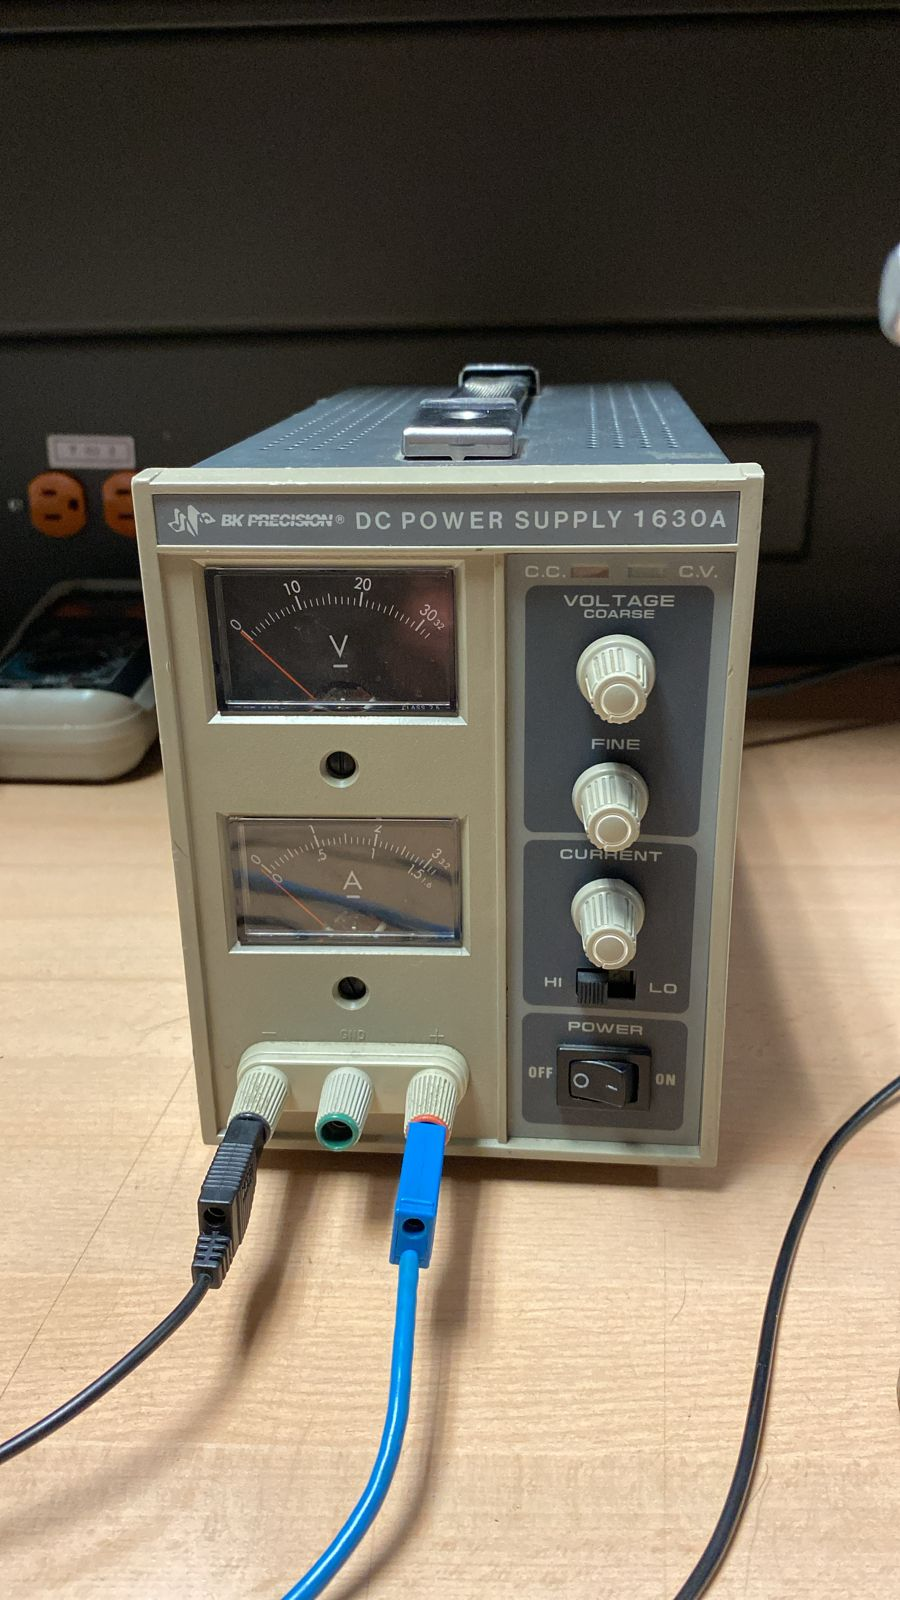

---

**Nota:** Para poder replicar las mediciones que realizamos es importante calibrar la fuente de alimentación AC, no con los 12V y 5A que se encuentran descritos en la Guía de Laboratorio del experimento, sino con la perilla apuntando al valor de 17 (número 15 grande más dos rayas, tal y como se observa en la imagen asociada a esta fuente) del círculo interior del panel indicativo, realizando las conexiones en la zona izquierda de la fuente. De parte de la fuente DC sólo hay que aumentar el voltaje al máximo de su valor, los cambios en el campo magnético se lograrán modificando los valores de corriente.

---

> ## Propagación de Error: Incertidumbre de los Instrumentos.

En el montaje utilizado nos encontramos con dos dispositivos digitales que nos proveían de la información necesaria para todas y cada una de las mediciones que se muestran en las siguientes líneas. Estos instrumentos de medición fueron: un multímetro y el Módulo de Hall. Como es costumbre con los instrumentos digitales, el grado de indeterminación en la medida se compone por su mínimo incremento, es decir:

$$\sigma_{V} = 0.001 \text{V} \quad \quad \quad \quad \sigma_{A} = 0.01 \text{A} \quad \quad \quad \quad \sigma_{A'} = 0.001$$

donde $\sigma_{V}$ es la incertidumbre que se asociará al voltaje de Hall y voltaje longitudinal, $\sigma_{A}$ es la incertidumbre asociada a la corriente que determina el campo magnético y $\sigma_{A'}$ es la incertidumbre del amperimetro del Módulo de Hall para su corriente en cuestión.

In [3]:
Unc_V = 0.001
Unc_A = 0.01
Unc_mA = 0.001

> ## Actividad #1: Caracterización del campo magnético generado por las bobinas: 

> **(15 de Agosto de 2024)**

---

A continuación se muestra la regresión que nos permitirá determinar el valor del campo magnético con el que nos encontramos trabajando sólo conociendo la corriente que la fuente de corriente directa está entregando a las bobinas. Para ello se hizo uso de un teslámetro que nos ayudó a hacer un barrido de mediciones del campo magnético al regular los valores de corriente que provee la fuente de corriente directa:



In [4]:
B_Field_Reg = "B_Field_Reg.xlsx"
B_Regression = pd.read_excel(path + B_Field_Reg)
B_Regression

,I (A),B (mT)
0,0.00,6.2
1,0.10,28.2
2,0.20,46.8
3,0.30,70.6
4,0.40,90.7
5,0.51,119.5
6,0.60,133.6
7,0.70,160.3
8,0.81,181.4
9,1.00,200.6


In [5]:
# Separar los datos de la tabla:
current = B_Regression["I (A)"].to_numpy(dtype = "float")
mag_field = B_Regression["B (mT)"].to_numpy(dtype = "float")*1/1000

# Realización del ajuste lineal:
coeff, cov = np.polyfit(current, mag_field, 1, cov = True)
uncertainty = np.sqrt(np.diag(cov)) # Incertidumbre de los coeficientes.

# Grafica con el ajuste:
R_current = np.linspace(current[0], current[-1], 100)
R_mag_field = coeff[0]*R_current + coeff[1]

print("Coeficiente m: " + str(round(coeff[0], 3)) + " +/- " + str(round(uncertainty[0], 3)))

Coeficiente m: 0.205 +/- 0.007


In [6]:
print("Coeficiente b: " + str(round(coeff[1], 3)) + " +/- " + str(round(uncertainty[1], 3)))

Coeficiente b: 0.009 +/- 0.004


In [7]:
def Error(value, uncertainty):
    true_unc = float('%.*g' % (1, uncertainty))
    if "e" in str(uncertainty):
        ward = int(str(uncertainty)[-2:])
    else:
        ward = str(true_unc)[::-1].find('.')
    true_value = round(value, ward)
    return true_value, true_unc

def Product_Error(valueA, valueB, UncA, UncB, mode, const = 1):
    value = valueA*valueB*const
    
    if mode == True:
        Unc = np.abs(const) * np.abs(value) * ((UncA/np.abs(valueA))**2 + (UncB/np.abs(valueB))**2)**(0.5) # Para productos.
    elif mode == False:
        Unc = np.abs(const) * np.abs(value) * ((UncA/np.abs(valueA))**2 + (UncB*np.abs(valueB))**2)**(0.5) # Para cocientes.

    value, Unc = Error(value, Unc)

    return value, Unc

def Magnetic_Field(current): # Función que determina el campo magnético en Teslas en función de Amperios.
    B_field = round(coeff[0], 3)*current + round(coeff[1], 3)
    
    if current != 0:
        B_fieldUnc = np.abs(round(coeff[0], 3)*current)*((round(uncertainty[0], 3)/np.abs(round(coeff[0], 3))) + (Unc_A/np.abs(current))) + round(uncertainty[1], 3) 
    else:
        B_fieldUnc = round(uncertainty[1], 3)
                           
    B_field, B_fieldUnc = Error(B_field, B_fieldUnc)
    return B_field, B_fieldUnc

def power_law(B, a, b, c): # Función necesaria para el ajuste de potencias.
    return a*(B**b) + c

def inverse_n(Rh, a):
    return a/(Rh*e)

def inverse_p(Rh, a):
    return a/(Rh*e)

In [8]:
Res_mag_field = []
for i in range(0, len(current)):
    Residue = mag_field[i] - (coeff[0]*current[i] + coeff[1])
    Res_mag_field.append(Residue)

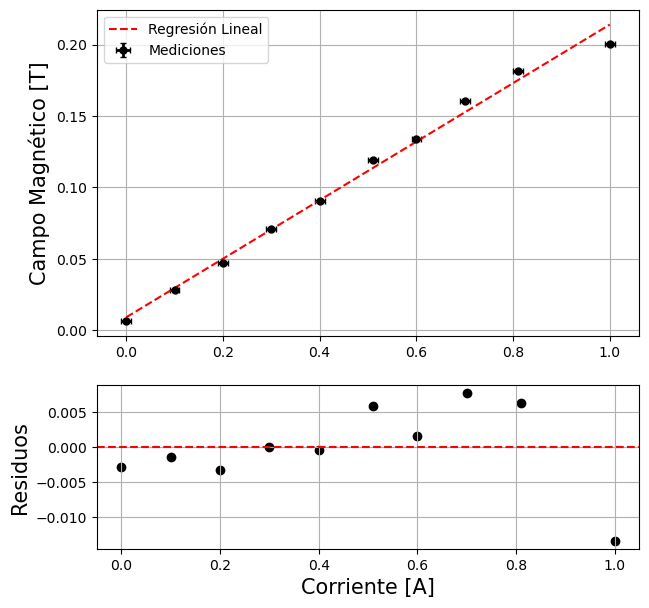

In [9]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0].errorbar(current, mag_field, xerr = 0.01, yerr = 0.0001, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='black',ecolor='black', label='Mediciones')
axis[0].plot(R_current, R_mag_field, color = "red", label = "Regresión Lineal", linestyle = "--")
axis[0].set_ylabel("Campo Magnético [T]", fontsize = 15)
axis[0].legend()
axis[0].grid(True)

axis[1].scatter(current, Res_mag_field, marker='o', color = 'black')
axis[1].axhline(y = 0, color = "red", linestyle = "--")
axis[1].set_ylabel("Residuos", fontsize = 15)
axis[1].set_xlabel("Corriente [A]", fontsize = 15)
axis[1].grid(True)
plt.savefig("Mag_Field_Regression.pdf")

Como se logra observar, la relación corriente-campo magnético es completamente lineal. Cabe destacar que a lo largo del experimento se buscará prevalecer en ese intervalo de cerca de $-200mT < B_{z} < 200mT$, a menos que la actividad requiera lo contrario.

> ## Actividad #2: Medición de voltaje de Hall para tarjetas n-Ge y p-Ge:

---

En esta segunda actividad nos centraremos en determinar el comportamiento del coeficiente de Hall a lo largo de diversos escenarios, ya sea manteniendo el campo magnético inducido constante (aquí llamado inciso **#1**) y variando así la corriente del Módulo de Hall, o viceversa (el entendido como inciso **#2**). De esta manera conseguiremos los valores del coeficiente de Hall en cada uno de los escenarios y haremos las regresiones necesarias.

---

> **n-Ge:** 

En este apartado se mostrarán los valores obtenidos para el conductor de tipo N. Empezando con el inciso **#1**, las mediciones de la corriente del módulo Hall a campo magnético constante son:

In [10]:
n_b_const = "n-Ge B_const.xlsx"
n_b_currents = ["0.2", "0.35", "0.46", "0.58", "0.70", "0.84"]
nReg_b_const = pd.read_excel(path + n_b_const)
nReg_b_const

,Ip (0.2),VH (0.2),Ip (0.35),VH (0.35),Ip (0.46),VH (0.46),Ip (0.58),VH (0.58),Ip (0.70),VH (0.70),Ip (0.84),VH (0.84)
0,-30,0.005,-30,0.012,-30,0.016,-30,0.022,-30,0.027,-30,0.034
1,-24,0.004,-24,0.009,-24,0.013,-24,0.018,-24,0.021,-24,0.026
2,-18,0.002,-18,0.006,-18,0.009,-18,0.013,-18,0.016,-18,0.020
3,-12,0.001,-12,0.004,-12,0.006,-12,0.009,-12,0.011,-12,0.014
4,-6,0.000,-6,0.001,-6,0.003,-6,0.004,-6,0.006,-6,0.007
5,0,-0.001,0,0.000,0,0.000,0,0.000,0,0.000,0,0.000
6,6,-0.002,6,-0.003,6,-0.004,6,-0.005,6,-0.006,6,-0.007
7,12,-0.004,12,-0.006,12,-0.007,12,-0.009,12,-0.010,12,-0.013
8,18,-0.005,18,-0.008,18,-0.010,18,-0.014,18,-0.016,18,-0.020
9,24,-0.006,24,-0.010,24,-0.014,24,-0.018,24,-0.022,24,-0.026


A este conjunto de datos se les realizará una regresión lineal de la cual sólo nos interesa recuperar el valor de la pendiente. De esta manera será posible recuperar los valores del coeficiente de Hall, sólo despejando la ecuación:

$$R_{H} = \frac{V_{H}w}{I_{p}B_{z}} \quad \Rightarrow \quad V_{H} = \frac{B_{z}R_{H}}{w} \cdot I_{p} \quad \Rightarrow \quad m = \frac{B_{z}R_{H}}{w} \quad \Rightarrow \quad R_{H} = \frac{mw}{B_z}$$

donde $m$ es la pendiente de la regresión lineal, $B_{z}$ el campo magnético, $R_{H}$ el coeficiente de Hall que queremos hallar y $w = 1 \times 10^{-3}$m el valor del grosor de la placa de Germanio.

In [11]:
n_b_slopes = []
n_b_slopesUnc = []

# El primer ciclo busca determinar los valores de las pendientes de cada regresión lineal.
for i in range(0, len(n_b_currents)):
    n_b_current = nReg_b_const["Ip (" + n_b_currents[i] + ")"].to_numpy(dtype = "float") * 1/1000
    n_b_hallv = nReg_b_const["VH (" + n_b_currents[i] + ")"].to_numpy(dtype = "float")
    
    n_b_coeff, n_b_cov = np.polyfit(n_b_current, n_b_hallv, 1, cov = True)
    n_bslope, n_bbias = n_b_coeff
    n_bslopeunc, n_bbiasunc = np.sqrt(np.diag(n_b_cov))
    
    values = Error(n_bslope, n_bslopeunc)
    n_b_slopes.append(values[0])
    n_b_slopesUnc.append(values[1])

print("Los valores de las pendientes con su incertidumbre son:")
for i in range(0, len(n_b_slopes)):
    data = Magnetic_Field(float(n_b_currents[i]))
    value, unc = data
    print(f"Para el campo magnético Bz = {value} +/- {unc} T, la pendiente es de m {n_b_slopes[i]} +/- {n_b_slopesUnc[i]} V/Ohm" )

Los valores de las pendientes con su incertidumbre son:
Para el campo magnético Bz = 0.05 +/- 0.007 T, la pendiente es de m -0.202 +/- 0.005 V/Ohm
Para el campo magnético Bz = 0.081 +/- 0.009 T, la pendiente es de m -0.405 +/- 0.008 V/Ohm
Para el campo magnético Bz = 0.103 +/- 0.009 T, la pendiente es de m -0.55 +/- 0.005 V/Ohm
Para el campo magnético Bz = 0.13 +/- 0.01 T, la pendiente es de m -0.742 +/- 0.005 V/Ohm
Para el campo magnético Bz = 0.15 +/- 0.01 T, la pendiente es de m -0.897 +/- 0.007 V/Ohm
Para el campo magnético Bz = 0.18 +/- 0.01 T, la pendiente es de m -1.108 +/- 0.007 V/Ohm


In [12]:
n_BRh_values = np.array([])
n_BRhUncs = []
n_B_values = np.array([])
n_BUncs = []

# Este segundo ciclo calcula el coeficiente de Hall y determina el campo magnético en cuestión:
for i in range(0, len(n_b_slopes)):
    n_B, n_BUnc = Magnetic_Field(float(n_b_currents[i]))
    n_BRh, n_BRhUnc = Product_Error(n_b_slopes[i], 1/n_B, n_b_slopesUnc[i], n_BUnc, mode = False, const = 1e-3)
    
    n_BRh_values = np.append(n_BRh_values, n_BRh)
    n_BRhUncs.append(n_BRhUnc)
    n_B_values = np.append(n_B_values, n_B)
    n_BUncs.append(n_BUnc)

print("Los valores del coeficiente de Hall (aún sin incertidumbres) son:")
for i in range(0, len(n_BRh_values)):
    print(f"Para el campo magnético Bz = {n_B_values[i]} +/- {n_BUncs[i]} T, el coeficiente de Hall es de {n_BRh_values[i]} +/- {n_BRhUncs[i]} m^3/C" )

Los valores del coeficiente de Hall (aún sin incertidumbres) son:
Para el campo magnético Bz = 0.05 +/- 0.007 T, el coeficiente de Hall es de -0.00404 +/- 6e-07 m^3/C
Para el campo magnético Bz = 0.081 +/- 0.009 T, el coeficiente de Hall es de -0.005 +/- 6e-07 m^3/C
Para el campo magnético Bz = 0.103 +/- 0.009 T, el coeficiente de Hall es de -0.0053398 +/- 5e-07 m^3/C
Para el campo magnético Bz = 0.13 +/- 0.01 T, el coeficiente de Hall es de -0.0057077 +/- 4e-07 m^3/C
Para el campo magnético Bz = 0.15 +/- 0.01 T, el coeficiente de Hall es de -0.00598 +/- 4e-07 m^3/C
Para el campo magnético Bz = 0.18 +/- 0.01 T, el coeficiente de Hall es de -0.0061556 +/- 3e-07 m^3/C


Podemos observar que el coeficiente de Hall tiene un comportamiento de decrecimiento continuo al incrementar su valor de campo magnético. Recordemos que una de las definiciones a las que se llega para el coeficiente de Hall en portadores de carga negativo es:

$$R_{H} = -\frac{1}{n_{e}e}$$

donde $n_{e}$ es el número de portadores de carga negativa y $e$ la carga del electrón. De esta manera podemos asegurar que sí estamos trabajando con la placa de Germanio n-Ge.

---

**#2:** Si nos remontamos a la teoría, el comportamiento que debe tener el coeficiente de Hall al determinar una corriente en el Módulo constante y aplicamos cambios en el campo magnético de las bobinas, el comportamiento de la relación de estos valores se vuelve:

$$R_{H} = \frac{V_{H}w}{I_{p}B_{z}} \quad \Rightarrow \quad V_{H} = \frac{I_{p}R_{H}}{w} \cdot B_{z} \quad \Rightarrow \quad m = \frac{I_{p}R_{H}}{w} \quad \Rightarrow \quad R_{H} = \frac{mw}{I_{p}} $$


Nótese que el comportamiento del coeficiente de Hall con respecto al campo magnético del sistema es inversamente proporcional. En teoría entonces, a campo magnético nulo debe existir un coeficiente de Hall infinito, lo cual es consistente con la teoría. El otro escenario, para corriente constante dice:

In [13]:
n_I_const = "n-Ge I_const.xlsx"
n_I_currents = np.array([-30, -20, -10, 10, 20, 30]) # Corriente en mA.
n_I_longv = ["-1.301", "-0.922", "-0.480", "0.361", "0.772", "1.207"] # Voltaje longitudinal. (Se invirtió para probar un punto)
nReg_I_const = pd.read_excel(path + n_I_const)
nReg_I_const

,B (-30),VH (VL = -1.301),B (-20),VH (VL = -0.922),B (-10),VH (VL = -0.480),B (10),VH (VL = 0.361),B (20),VH (VL = 0.772),B (30),VH (VL = 1.207)
0,-0.55,-0.029,-0.55,-0.020,-0.55,-0.012,-0.55,0.007,-0.55,0.015,-0.55,0.024
1,-0.45,-0.025,-0.45,-0.017,-0.45,-0.010,-0.45,0.005,-0.45,0.013,-0.45,0.020
2,-0.35,-0.021,-0.35,-0.014,-0.35,-0.009,-0.35,0.004,-0.35,0.010,-0.35,0.016
3,-0.25,-0.015,-0.25,-0.011,-0.25,-0.007,-0.25,0.003,-0.25,0.007,-0.25,0.011
4,-0.15,-0.011,-0.15,-0.008,-0.15,-0.005,-0.15,0.001,-0.15,0.004,-0.15,0.008
5,0.00,-0.004,0.00,-0.003,0.00,-0.002,0.00,0.000,0.00,0.000,0.00,0.001
6,0.15,0.001,0.15,0.001,0.15,0.000,0.15,-0.002,0.15,-0.003,0.15,-0.004
7,0.25,0.006,0.25,0.004,0.25,0.002,0.25,-0.003,0.25,-0.006,0.25,-0.008
8,0.35,0.011,0.35,0.007,0.35,0.003,0.35,-0.005,0.35,-0.009,0.35,-0.012
9,0.45,0.015,0.45,0.010,0.45,0.005,0.45,-0.006,0.45,-0.011,0.45,-0.016


In [14]:
n_I_ward = nReg_I_const["B (-30)"].to_numpy(dtype = "float")
n_I_slopes = []
n_I_slopesUnc = []
n_I_bfield = []
n_I_bfieldUnc = []

for i in n_I_ward:
    value, unc = Magnetic_Field(i)
    n_I_bfield.append(value)
    n_I_bfieldUnc.append(unc)

# El primer ciclo busca determinar los valores de las pendientes de cada regresión lineal.
for i in range(0, len(n_I_currents)):
    n_I_hallv = nReg_I_const["VH (VL = " + n_I_longv[i] + ")"].to_numpy(dtype = "float")
    
    n_I_coeff, n_I_cov = np.polyfit(n_I_bfield, n_I_hallv, 1, cov = True)
    n_Islope, n_Ibias = n_I_coeff
    n_Islopeunc, n_Ibiasunc = np.sqrt(np.diag(n_b_cov))
    
    values = Error(n_Islope, n_Islopeunc)
    n_I_slopes.append(values[0])
    n_I_slopesUnc.append(values[1])

print("Los valores de las pendientes con su incertidumbre son:")
for i in range(0, len(n_I_slopes)):
    print(f"Para la corriente Ip = {n_I_currents[i]} +/- 1 mA, la pendiente es de m {n_I_slopes[i]} +/- {n_I_slopesUnc[i]} V/Ohm" )

Los valores de las pendientes con su incertidumbre son:
Para la corriente Ip = -30 +/- 1 mA, la pendiente es de m 0.219 +/- 0.007 V/Ohm
Para la corriente Ip = -20 +/- 1 mA, la pendiente es de m 0.148 +/- 0.007 V/Ohm
Para la corriente Ip = -10 +/- 1 mA, la pendiente es de m 0.084 +/- 0.007 V/Ohm
Para la corriente Ip = 10 +/- 1 mA, la pendiente es de m -0.061 +/- 0.007 V/Ohm
Para la corriente Ip = 20 +/- 1 mA, la pendiente es de m -0.13 +/- 0.007 V/Ohm
Para la corriente Ip = 30 +/- 1 mA, la pendiente es de m -0.196 +/- 0.007 V/Ohm


In [15]:
n_IRh_values = []
n_IRhUncs = []
n_I_values = np.array([-0.030, -0.020, -0.010, 0.010, 0.020, 0.030])

# Este segundo ciclo calcula el coeficiente de Hall:
for i in range(0, len(n_b_slopes)):
    n_IRh, n_IRhUnc = Product_Error(n_I_slopes[i], 1/float(n_I_values[i]), n_I_slopesUnc[i], 0.001, mode = False, const = 1e-3)

    n_IRh_values.append(n_IRh)
    n_IRhUncs.append(n_IRhUnc)

    
print("Los valores del coeficiente de Hall son:")
for i in range(0, len(n_IRh_values)):
    print(f"Para la corriente Ip = {n_I_currents[i]} +/- 1 mA, el coeficiente de Hall es de {n_IRh_values[i]} +/- {n_IRhUncs[i]} m^3/C" )

Los valores del coeficiente de Hall son:
Para la corriente Ip = -30 +/- 1 mA, el coeficiente de Hall es de -0.0073 +/- 3e-07 m^3/C
Para la corriente Ip = -20 +/- 1 mA, el coeficiente de Hall es de -0.0074 +/- 5e-07 m^3/C
Para la corriente Ip = -10 +/- 1 mA, el coeficiente de Hall es de -0.0084 +/- 1e-06 m^3/C
Para la corriente Ip = 10 +/- 1 mA, el coeficiente de Hall es de -0.0061 +/- 9e-07 m^3/C
Para la corriente Ip = 20 +/- 1 mA, el coeficiente de Hall es de -0.0065 +/- 5e-07 m^3/C
Para la corriente Ip = 30 +/- 1 mA, el coeficiente de Hall es de -0.0065333 +/- 3e-07 m^3/C


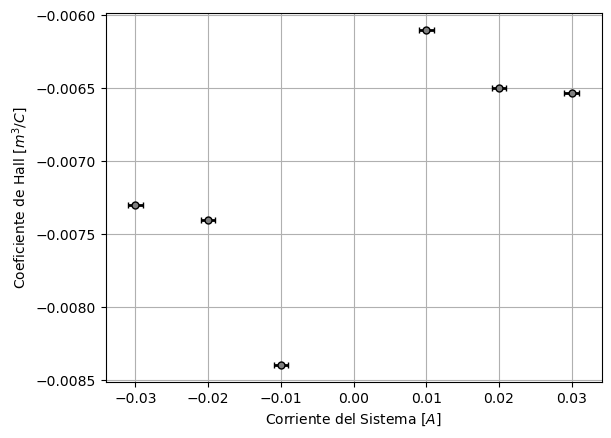

In [16]:
plt.errorbar(n_I_values, n_IRh_values, xerr = 0.001, yerr = n_IRhUncs, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Corriente del Sistema $[A]$")
plt.ylabel(r"Coeficiente de Hall $[m^3/C]$")
plt.grid(True)

Esta gráfica anterior es solo una muestra de la relación de proporcionalidad inversa que existe entre la corriente del Módulo de Hall y el coeficiente de Hall (solo es ilustrativa, no cumple ningún propósito en los análisis más allá de verificar tendencias). Con base en la información obtenida, la expresión para la conductividad en cada caso de corriente son:

$$\sigma = \frac{lI_{p}}{V_{L}A}$$

Dado que para corrientes positivas el volaje longitudinal es positivo y viceversa, la relación en cuestión es la esperada (recordar que el valor de la conductividad es siempre positivo).

In [17]:
n_ISigmas = []
n_ISigmasUnc = []
constant = 10e-3/(1e-3*20e-3)

for i in range(0, len(n_I_values)):   
    n_ISigma, n_ISigmaUnc = Product_Error(n_I_values[i], 1/float(n_I_longv[i]), 0.001, 0.001, mode = False, const = constant)
    n_ISigmas.append(n_ISigma)
    n_ISigmasUnc.append(n_ISigmaUnc)
    
print("Los valores del coeficiente de conductividad son:")
for i in range(0, len(n_ISigmas)):
    print(f"Para la corriente Ip = {n_I_currents[i]} +/- 1 mA, la conductividad es de {1/n_ISigmas[i]} +/- {n_ISigmasUnc[i]} 1/Ωm")

Los valores del coeficiente de conductividad son:
Para la corriente Ip = -30 +/- 1 mA, la conductividad es de 0.08695652173913043 +/- 200.0 1/Ωm
Para la corriente Ip = -20 +/- 1 mA, la conductividad es de 0.09259259259259259 +/- 300.0 1/Ωm
Para la corriente Ip = -10 +/- 1 mA, la conductividad es de 0.09615384615384615 +/- 500.0 1/Ωm
Para la corriente Ip = 10 +/- 1 mA, la conductividad es de 0.07194244604316546 +/- 700.0 1/Ωm
Para la corriente Ip = 20 +/- 1 mA, la conductividad es de 0.07692307692307693 +/- 300.0 1/Ωm
Para la corriente Ip = 30 +/- 1 mA, la conductividad es de 0.08064516129032258 +/- 200.0 1/Ωm


Por otro lado, el valor asociado a la movilidad de los portadores de carga negativos será:

In [18]:
n_IMus = []
n_IMusUnc = []

for i in range(0, len(n_IRh_values)):   
    n_IMu, n_IMuUnc = Product_Error(np.abs(n_IRh_values[i]), n_ISigmas[i], n_IRhUncs[i], n_ISigmasUnc[i], mode = True, const = 1)
    n_IMus.append(n_IMu)
    n_IMusUnc.append(n_IMuUnc)

print("Los valores del coeficiente de conductividad son:")
for i in range(0, len(n_IMus)):
    print(f"Para la corriente Ip = {n_I_currents[i]} +/- 1 mA, la movilidad es de {1/n_IMus[i]} +/- {n_IMusUnc[i]} 1/Ωm")

Los valores del coeficiente de conductividad son:
Para la corriente Ip = -30 +/- 1 mA, la movilidad es de 10.0 +/- 1.0 1/Ωm
Para la corriente Ip = -20 +/- 1 mA, la movilidad es de 10.0 +/- 2.0 1/Ωm
Para la corriente Ip = -10 +/- 1 mA, la movilidad es de 10.0 +/- 4.0 1/Ωm
Para la corriente Ip = 10 +/- 1 mA, la movilidad es de 10.0 +/- 4.0 1/Ωm
Para la corriente Ip = 20 +/- 1 mA, la movilidad es de 10.0 +/- 2.0 1/Ωm
Para la corriente Ip = 30 +/- 1 mA, la movilidad es de 10.0 +/- 1.0 1/Ωm


Para estos dos últimos conjuntos de datos (conductividad y movilidad) se obtuvieron valores extraños. Dado que este es un análisos preliminar se omitirá el análisis de este apartado (extrañamente la incertidumbre "explota") por el momento. Se aspira a una mayor precisión para el informe final.

---

> **p-Ge:** 

En esta segunda sección se replicarán los procedimientos realizados en el punto anterior para el conductor de tipo p-Ge. Nótese que en gran parte las explicaciones de lo que se hace son equivalentes, variando sólo en signo. Por tanto obtenemos, para el inciso **#1** para campo magnético constante y corriente del Módulo de Hall variable:

In [19]:
p_b_const = "p-Ge B_const.xlsx"
p_b_currents = ["0.2", "0.35", "0.46", "0.58", "0.70", "0.84"]
pReg_b_const = pd.read_excel(path + p_b_const)
pReg_b_const

,Ip (0.2),VH (0.2),Ip (0.35),VH (0.35),Ip (0.46),VH (0.46),Ip (0.58),VH (0.58),Ip (0.70),VH (0.70),Ip (0.84),VH (0.84)
0,-30,-0.007,-30,-0.012,-30,-0.016,-30,-0.021,-30,-0.027,-30,-0.030
1,-24,-0.005,-24,-0.009,-24,-0.013,-24,-0.016,-24,-0.022,-24,-0.025
2,-18,-0.004,-18,-0.007,-18,-0.010,-18,-0.013,-18,-0.017,-18,-0.019
3,-12,-0.003,-12,-0.005,-12,-0.007,-12,-0.009,-12,-0.011,-12,-0.012
4,-6,-0.001,-6,-0.002,-6,-0.003,-6,-0.005,-6,-0.005,-6,-0.007
5,0,0.000,0,0.000,0,0.000,0,0.000,0,0.000,0,0.000
6,6,0.001,6,0.001,6,0.002,6,0.003,6,0.004,6,0.005
7,12,0.002,12,0.004,12,0.006,12,0.007,12,0.009,12,0.011
8,18,0.004,18,0.006,18,0.009,18,0.011,18,0.014,18,0.016
9,24,0.005,24,0.009,24,0.012,24,0.015,24,0.019,24,0.021


In [20]:
p_b_slopes = []
p_b_slopesUnc = []

# El primer ciclo busca determinar los valores de las pendientes de cada regresión lineal.
for i in range(0, len(p_b_currents)):
    p_b_current = pReg_b_const["Ip (" + p_b_currents[i] + ")"].to_numpy(dtype = "float") * 1/1000
    p_b_hallv = pReg_b_const["VH (" + p_b_currents[i] + ")"].to_numpy(dtype = "float")
    
    p_b_coeff, p_b_cov = np.polyfit(p_b_current, p_b_hallv, 1, cov = True)
    p_bslope, p_bbias = p_b_coeff
    p_bslopeunc, p_bbiasunc = np.sqrt(np.diag(p_b_cov))
    
    values = Error(p_bslope, p_bslopeunc)
    p_b_slopes.append(values[0])
    p_b_slopesUnc.append(values[1])

print("Los valores de las pendientes con su incertidumbre son:")
for i in range(0, len(p_b_slopes)):
    data = Magnetic_Field(float(p_b_currents[i]))
    value, unc = data
    print(f"Para el campo magnético Bz = {value} +/- {unc} T, la pendiente es de m {p_b_slopes[i]} +/- {p_b_slopesUnc[i]} V/Ohm" )

Los valores de las pendientes con su incertidumbre son:
Para el campo magnético Bz = 0.05 +/- 0.007 T, la pendiente es de m 0.221 +/- 0.006 V/Ohm
Para el campo magnético Bz = 0.081 +/- 0.009 T, la pendiente es de m 0.374 +/- 0.007 V/Ohm
Para el campo magnético Bz = 0.103 +/- 0.009 T, la pendiente es de m 0.52 +/- 0.006 V/Ohm
Para el campo magnético Bz = 0.13 +/- 0.01 T, la pendiente es de m 0.668 +/- 0.008 V/Ohm
Para el campo magnético Bz = 0.15 +/- 0.01 T, la pendiente es de m 0.85 +/- 0.01 V/Ohm
Para el campo magnético Bz = 0.18 +/- 0.01 T, la pendiente es de m 0.96 +/- 0.01 V/Ohm


In [21]:
p_BRh_values = np.array([])
p_BRhUncs = []
p_B_values = np.array([])
p_BUncs = []

# Este segundo ciclo calcula el coeficiente de Hall y determina el campo magnético en cuestión:
for i in range(0, len(p_b_slopes)):
    p_B, p_BUnc = Magnetic_Field(float(p_b_currents[i]))
    p_BRh, p_BRhUnc = Product_Error(p_b_slopes[i], 1/p_B, p_b_slopesUnc[i], p_BUnc, mode = False, const = 1e-3)
    
    p_BRh_values = np.append(p_BRh_values, p_BRh)
    p_BRhUncs.append(p_BRhUnc)
    p_B_values = np.append(p_B_values, p_B)
    p_BUncs.append(p_BUnc)

print("Los valores del coeficiente de Hall (aún sin incertidumbres) son:")
for i in range(0, len(p_BRh_values)):
    print(f"Para el campo magnético Bz = {p_B_values[i]} +/- {p_BUncs[i]} T, el coeficiente de Hall es de {p_BRh_values[i]} +/- {p_BRhUncs[i]} m^3/C" )

Los valores del coeficiente de Hall (aún sin incertidumbres) son:
Para el campo magnético Bz = 0.05 +/- 0.007 T, el coeficiente de Hall es de 0.00442 +/- 6e-07 m^3/C
Para el campo magnético Bz = 0.081 +/- 0.009 T, el coeficiente de Hall es de 0.0046173 +/- 5e-07 m^3/C
Para el campo magnético Bz = 0.103 +/- 0.009 T, el coeficiente de Hall es de 0.0050485 +/- 4e-07 m^3/C
Para el campo magnético Bz = 0.13 +/- 0.01 T, el coeficiente de Hall es de 0.0051385 +/- 4e-07 m^3/C
Para el campo magnético Bz = 0.15 +/- 0.01 T, el coeficiente de Hall es de 0.0056667 +/- 4e-07 m^3/C
Para el campo magnético Bz = 0.18 +/- 0.01 T, el coeficiente de Hall es de 0.0053333 +/- 3e-07 m^3/C


Como se puede apreciar, existe una inconsistencia en el coeficiente de Hall de la última serie de datos tomada. Dicho salto no lo podemos explicar en este momento, lo más seguro es que el valor sea producto de un error sistemático, así que es candidato a ser excluido. Por otro lado, nótese que la tendencia de crecimiento que se espera en la tarjeta p-Ge se satisface en tando se observa que el coeficiente de Hall es netamente incremental e inversamente proporcional a la cantidad de portadores de carga positiva:

$$R_{H} = \frac{1}{n_{h}e}$$

---

Ahora bien, replicando los resultados del inciso **#2** para la placa de p-Ge obtenemos como resultados:

In [22]:
p_I_const = "p-Ge I_const.xlsx"
p_I_currents = ["-30", "-20", "-10", "10", "20", "30"] # Corriente en mA.
p_I_longv = ["-1.006", "-0.728 ", "-0.407", "0.315", "0.673", "0.971"] # Voltaje longitudinal.
pReg_I_const = pd.read_excel(path + p_I_const)
pReg_I_const

,B (-30),VH (VL = -1.006),B (-20),VH (VL = -0.728 ),B (-10),VH (VL = -0.407),B (10),VH (VL = 0.315),B (20),VH (VL = 0.673),B (30),VH (VL = 0.971)
0,-0.55,0.021,-0.55,0.015,-0.55,0.009,-0.55,-0.005,-0.55,-0.011,-0.55,-0.017
1,-0.45,0.017,-0.45,0.012,-0.45,0.007,-0.45,-0.003,-0.45,-0.009,-0.45,-0.014
2,-0.35,0.014,-0.35,0.010,-0.35,0.006,-0.35,-0.002,-0.35,-0.007,-0.35,-0.011
3,-0.25,0.011,-0.25,0.008,-0.25,0.005,-0.25,-0.001,-0.25,-0.005,-0.25,-0.008
4,-0.15,0.007,-0.15,0.005,-0.15,0.003,-0.15,0.000,-0.15,-0.003,-0.15,-0.004
5,0.00,0.002,0.00,0.001,0.00,0.001,0.00,0.000,0.00,0.000,0.00,0.000
6,0.15,-0.003,0.15,-0.002,0.15,0.000,0.15,0.002,0.15,0.004,0.15,0.005
7,0.25,-0.007,0.25,-0.004,0.25,-0.002,0.25,0.003,0.25,0.006,0.25,0.008
8,0.35,-0.011,0.35,-0.007,0.35,-0.003,0.35,0.004,0.35,0.009,0.35,0.012
9,0.45,-0.014,0.45,-0.009,0.45,-0.005,0.45,0.005,0.45,0.011,0.45,0.015


In [23]:
p_I_ward = nReg_I_const["B (-30)"].to_numpy(dtype = "float")
p_I_slopes = []
p_I_slopesUnc = []
p_I_bfield = []
p_I_bfieldUnc = []

for i in p_I_ward:
    value, unc = Magnetic_Field(i)
    p_I_bfield.append(value)
    p_I_bfieldUnc.append(unc)

# El primer ciclo busca determinar los valores de las pendientes de cada regresión lineal.
for i in range(0, len(p_I_currents)):
    p_I_hallv = pReg_I_const["VH (VL = " + p_I_longv[i] + ")"].to_numpy(dtype = "float")
    
    p_I_coeff, p_I_cov = np.polyfit(p_I_bfield, p_I_hallv, 1, cov = True)
    p_Islope, p_Ibias = p_I_coeff
    p_Islopeunc, p_Ibiasunc = np.sqrt(np.diag(p_b_cov))
    
    values = Error(p_Islope, p_Islopeunc)
    p_I_slopes.append(values[0])
    p_I_slopesUnc.append(values[1])

print("Los valores de las pendientes con su incertidumbre son:")
for i in range(0, len(p_I_slopes)):
    print(f"Para la corriente Ip = {p_I_currents[i]} +/- 1 mA, la pendiente es de m {p_I_slopes[i]} +/- {p_I_slopesUnc[i]} V/Ohm" )

Los valores de las pendientes con su incertidumbre son:
Para la corriente Ip = -30 +/- 1 mA, la pendiente es de m -0.17 +/- 0.01 V/Ohm
Para la corriente Ip = -20 +/- 1 mA, la pendiente es de m -0.12 +/- 0.01 V/Ohm
Para la corriente Ip = -10 +/- 1 mA, la pendiente es de m -0.07 +/- 0.01 V/Ohm
Para la corriente Ip = 10 +/- 1 mA, la pendiente es de m 0.05 +/- 0.01 V/Ohm
Para la corriente Ip = 20 +/- 1 mA, la pendiente es de m 0.11 +/- 0.01 V/Ohm
Para la corriente Ip = 30 +/- 1 mA, la pendiente es de m 0.16 +/- 0.01 V/Ohm


In [24]:
p_IRh_values = []
p_IRhUncs = []
p_I_values = np.array([-0.030, -0.020, -0.010, 0.010, 0.020, 0.030])

# Este segundo ciclo calcula el coeficiente de Hall:
for i in range(0, len(p_b_slopes)):
    p_IRh, p_IRhUnc = Product_Error(p_I_slopes[i], 1/float(p_I_values[i]), p_I_slopesUnc[i], 0.001, mode = False, const = 1e-3)

    p_IRh_values.append(p_IRh)
    p_IRhUncs.append(p_IRhUnc)

    
print("Los valores del coeficiente de Hall son:")
for i in range(0, len(p_IRh_values)):
    print(f"Para la corriente Ip = {p_I_currents[i]} +/- 1 mA, el coeficiente de Hall es de {p_IRh_values[i]} +/- {p_IRhUncs[i]} m^3/C" )

Los valores del coeficiente de Hall son:
Para la corriente Ip = -30 +/- 1 mA, el coeficiente de Hall es de 0.0056667 +/- 4e-07 m^3/C
Para la corriente Ip = -20 +/- 1 mA, el coeficiente de Hall es de 0.006 +/- 6e-07 m^3/C
Para la corriente Ip = -10 +/- 1 mA, el coeficiente de Hall es de 0.007 +/- 1e-06 m^3/C
Para la corriente Ip = 10 +/- 1 mA, el coeficiente de Hall es de 0.005 +/- 1e-06 m^3/C
Para la corriente Ip = 20 +/- 1 mA, el coeficiente de Hall es de 0.0055 +/- 6e-07 m^3/C
Para la corriente Ip = 30 +/- 1 mA, el coeficiente de Hall es de 0.0053333 +/- 4e-07 m^3/C


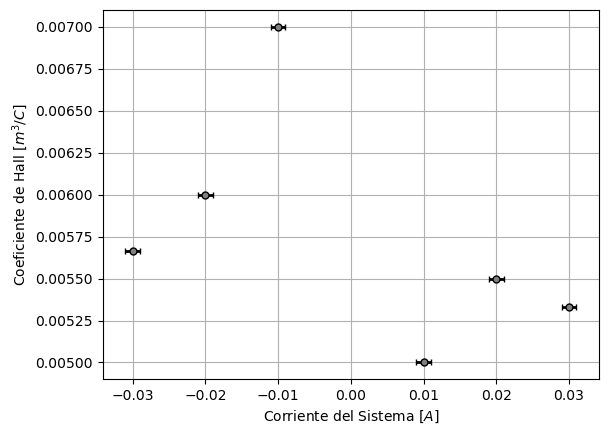

In [25]:
plt.errorbar(p_I_values, p_IRh_values, xerr = 0.001, yerr = p_IRhUncs, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Corriente del Sistema $[A]$")
plt.ylabel(r"Coeficiente de Hall $[m^3/C]$")
plt.grid(True)

Esta gráfica (similar al caso de la tarjeta n-Ge) es solo una muestra de la relación de proporcionalidad inversa que existe entre la corriente del Módulo de Hall y el coeficiente de Hall. Recordando la ecuación que describe esta relación:

$$\sigma = \frac{lI_{p}}{V_{L}A}$$

Dado que para corrientes positivas el volaje longitudinal es positivo y viceversa, la relación en cuestión es la esperada (recordar que el valor de la conductividad es siempre positivo), solo resulta en una inversión de la gráfica por la manera en que cambia el voltaje de Hall.

In [26]:
p_ISigmas = []
p_ISigmasUnc = []
constant = 10e-3/(1e-3*20e-3)

for i in range(0, len(p_I_values)):   
    p_ISigma = constant*p_I_values[i]/float(p_I_longv[i]) 
    p_ISigmaUnc = np.abs(p_ISigma)*((0.001/np.abs(p_I_values[i]))**2 + (0.001/np.abs(float(p_I_longv[i])))**2)**(0.5)
    p_ISigmas.append(p_ISigma)
    p_ISigmasUnc.append(p_ISigmaUnc)
    
print("Los valores del coeficiente de conductividad son:")
for i in range(0, len(p_ISigmas)):
    print(f"Para la corriente Ip = {p_I_currents[i]} +/- 1 mA, la conductividad es de {p_ISigmas[i]} +/- {p_ISigmasUnc[i]} 1/Ωm")

Los valores del coeficiente de conductividad son:
Para la corriente Ip = -30 +/- 1 mA, la conductividad es de 14.910536779324055 +/- 0.4972388416510983 1/Ωm
Para la corriente Ip = -20 +/- 1 mA, la conductividad es de 13.736263736263734 +/- 0.6870723205396343 1/Ωm
Para la corriente Ip = -10 +/- 1 mA, la conductividad es de 12.285012285012284 +/- 1.2288719871164822 1/Ωm
Para la corriente Ip = 10 +/- 1 mA, la conductividad es de 15.87301587301587 +/- 1.5881012355071225 1/Ωm
Para la corriente Ip = 20 +/- 1 mA, la conductividad es de 14.858841010401186 +/- 0.7432700392742944 1/Ωm
Para la corriente Ip = 30 +/- 1 mA, la conductividad es de 15.447991761071059 +/- 0.5151787677933579 1/Ωm


In [27]:
p_IMus = []
p_IMusUnc = []

for i in range(0, len(p_IRh_values)):   
    p_IMu, p_IMuUnc = Product_Error(np.abs(p_IRh_values[i]), p_ISigmas[i], p_IRhUncs[i], p_ISigmasUnc[i], mode = True, const = 1)
    p_IMus.append(p_IMu)
    p_IMusUnc.append(p_IMuUnc)

print("Los valores del coeficiente de conductividad son:")
for i in range(0, len(p_IMus)):
    print(f"Para la corriente Ip = {p_I_currents[i]} +/- 1 mA, la movilidad es de {p_IMus[i]} +/- {p_IMusUnc[i]} 1/Ωm")

Los valores del coeficiente de conductividad son:
Para la corriente Ip = -30 +/- 1 mA, la movilidad es de 0.084 +/- 0.003 1/Ωm
Para la corriente Ip = -20 +/- 1 mA, la movilidad es de 0.082 +/- 0.004 1/Ωm
Para la corriente Ip = -10 +/- 1 mA, la movilidad es de 0.086 +/- 0.009 1/Ωm
Para la corriente Ip = 10 +/- 1 mA, la movilidad es de 0.079 +/- 0.008 1/Ωm
Para la corriente Ip = 20 +/- 1 mA, la movilidad es de 0.082 +/- 0.004 1/Ωm
Para la corriente Ip = 30 +/- 1 mA, la movilidad es de 0.082 +/- 0.003 1/Ωm


De manera similar a la placa n-Ge, los valores obtenidos son inconsistentes. Se pulirá el análisis para el informe final.

---

> ## Gráficas Generales - Actividad #2:

**Primera medición:** En esta sección se muestra la gráfica asociada al primer de los apartados de la actividad relacionada con la medición del voltaje de Hall para las placas de n-Ge y p-Ge:

In [28]:
n_Bcoeff, n_Bcov = np.polyfit(n_B_values, n_BRh_values, 1, cov = True)
nB_unc = np.sqrt(np.diag(n_Bcov)) # Incertidumbre de los coeficientes.

nB_mag = np.linspace(n_B_values[0], n_B_values[-1], 100)
nB_rh = n_Bcoeff[0]*nB_mag + n_Bcoeff[1]

nB_magRes = []
for i in range(0, len(n_B_values)):
    Residue = n_BRh_values[i] - (n_Bcoeff[0]*n_B_values[i] + n_Bcoeff[1])
    nB_magRes.append(Residue)
    
p_Bcoeff, p_Bcov = np.polyfit(p_B_values, p_BRh_values, 1, cov = True)
pB_unc = np.sqrt(np.diag(p_Bcov)) # Incertidumbre de los coeficientes.

pB_mag = np.linspace(p_B_values[0], p_B_values[-1], 100)
pB_rh = p_Bcoeff[0]*pB_mag + p_Bcoeff[1]

pB_magRes = []
for i in range(0, len(p_B_values)):
    Residue = p_BRh_values[i] - (p_Bcoeff[0]*p_B_values[i] + p_Bcoeff[1])
    pB_magRes.append(Residue)

(0.0050374, 4e-07)
(-0.0053705, 5e-07)


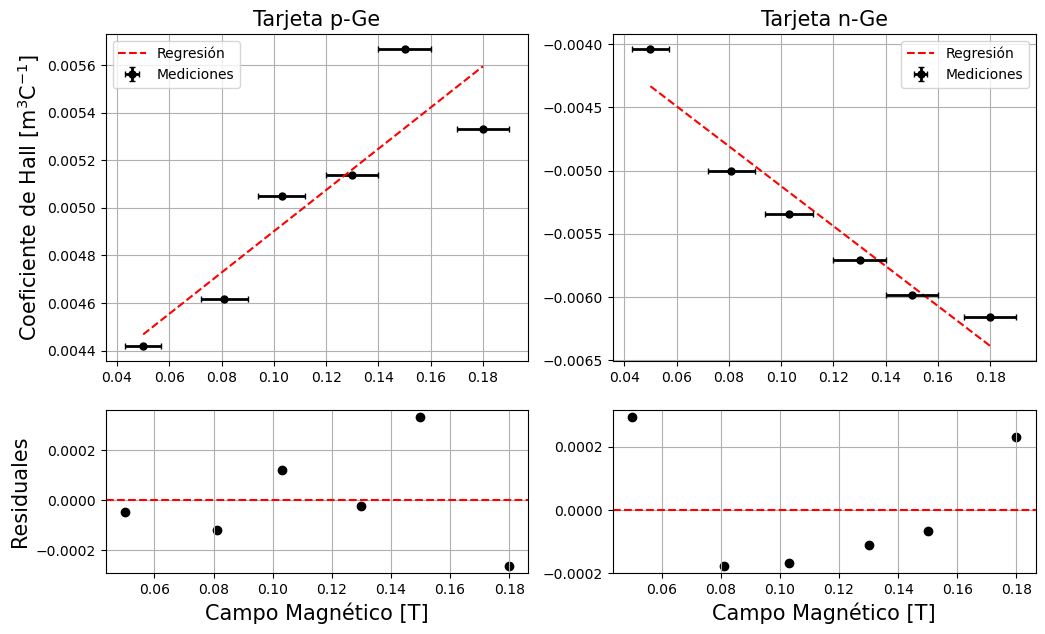

In [36]:
figure, axis = plt.subplots(2, 2, figsize = (12, 7), gridspec_kw={'height_ratios': [2, 1]})


axis[0, 0].errorbar(p_B_values, p_BRh_values, xerr = p_BUncs, yerr = p_BRhUncs, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[1, 0].scatter(p_B_values, pB_magRes, color = "black")
axis[1, 0].axhline(y = 0, color = "red", linestyle = "--")
axis[0, 0].plot(pB_mag, pB_rh, color = "red", linestyle = "--", label = "Regresión")
axis[0, 0].legend()

axis[0, 1].plot(nB_mag, nB_rh, color = "red", linestyle = "--", label = "Regresión")
axis[0, 1].errorbar(n_B_values, n_BRh_values, xerr = n_BUncs, yerr = n_BRhUncs, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[1, 1].scatter(n_B_values, nB_magRes, color = "black")
axis[1, 1].axhline(y = 0, color = "red", linestyle = "--")
axis[0, 1].legend()

axis[0, 1].set_title("Tarjeta n-Ge", fontsize = 15)
axis[0, 0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[1, 0].set_xlabel("Campo Magnético [T]", fontsize = 15)
axis[1, 1].set_xlabel("Campo Magnético [T]", fontsize = 15)
axis[1, 0].set_ylabel("Residuales", fontsize = 15)
axis[0, 0].set_ylabel(r"Coeficiente de Hall [m$^3$C$^{-1}$]", fontsize = 15)

axis[0, 0].grid(True)
axis[0, 1].grid(True)
axis[1, 0].grid(True)
axis[1, 1].grid(True)
val1 = np.sum(p_BRh_values)/len(p_BRh_values)
unc1 = np.sum(p_BRhUncs)/len(p_BRhUncs)
val2 = np.sum(n_BRh_values)/len(n_BRh_values)
unc2 = np.sum(n_BRhUncs)/len(n_BRhUncs)
print(Error(val1, unc1))
print(Error(val2, unc2))
plt.savefig("Hall_Coeff_Variation.pdf")

Partiendo de esta información se es posible hallar la densidad de los portadores de carga. El comportamiento se encuentra descrito a continuación:

In [108]:
n_density = np.array([])
nBRH = np.linspace(n_BRh_values[0], n_BRh_values[-1], 100)

for i in range(0, len(n_BRh_values)):
    density = -1/(n_BRh_values[i]*e)
    n_density = np.append(n_density, density)

n_densreg_coef, n_densreg_unc = curve_fit(inverse_n, n_BRh_values, n_density) 
n_densityReg = inverse_n(nBRH, *n_densreg_coef)

n_densityRes = []
for i in range(0, len(n_BRh_values)):
    residue = n_density[i] - inverse_n(n_BRh_values[i], *n_densreg_coef)
    n_densityRes.append(residue)
    
p_density = []
pBRH = np.linspace(p_BRh_values[0], max(p_BRh_values), 100)

for i in range(0, len(p_BRh_values)):
    density = 1/(p_BRh_values[i]*e)
    p_density.append(density)
    
p_densreg_coef, p_densreg_unc = curve_fit(inverse_p, p_BRh_values, p_density) 
p_densityReg = inverse_p(pBRH, *p_densreg_coef)

p_densityRes = []
for i in range(0, len(p_BRh_values)):
    residue = p_density[i] - inverse_p(p_BRh_values[i], *p_densreg_coef)
    p_densityRes.append(residue)

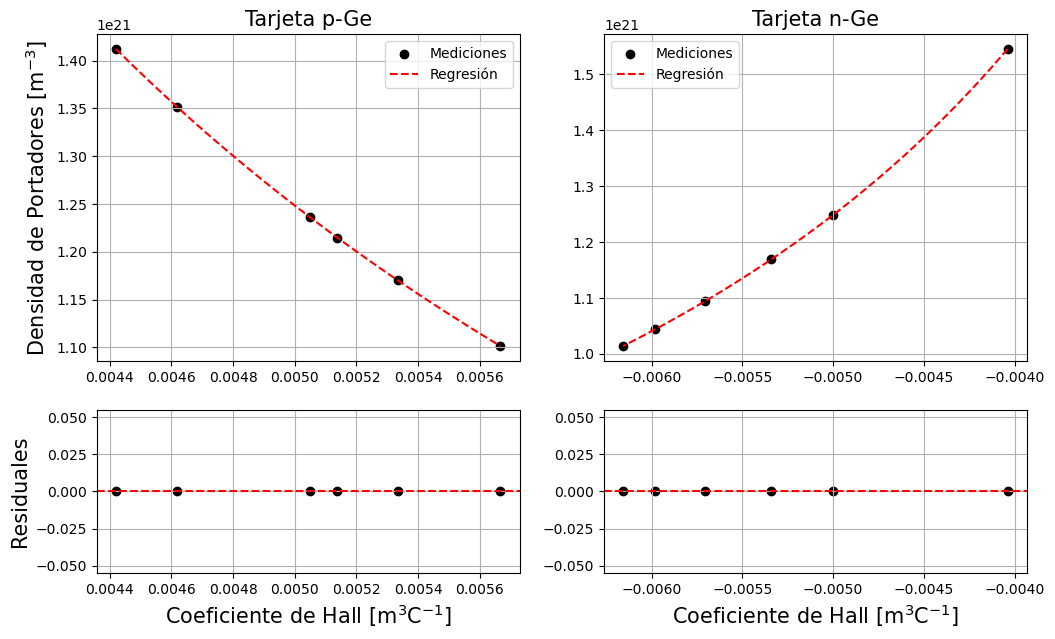

In [279]:
figure, axis = plt.subplots(2, 2, figsize = (12, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0, 1].scatter(n_BRh_values, n_density, color = "black", label =  "Mediciones")
axis[0, 1].plot(nBRH, n_densityReg, color = "red", linestyle = "--", label = "Regresión")
axis[0, 1].legend()
axis[0, 0].scatter(p_BRh_values, p_density, color = "black", label = "Mediciones")
axis[0, 0].plot(pBRH, p_densityReg, color = "red", linestyle = "--", label = "Regresión")
axis[0, 0].legend()
axis[1, 1].scatter(n_BRh_values, n_densityRes, color = "black")
axis[1, 0].scatter(p_BRh_values, p_densityRes, color = "black")

axis[1, 1].set_xlabel(r"Coeficiente de Hall [m$^{3}$C$^{-1}$]", fontsize = 15)
axis[1, 0].set_xlabel(r"Coeficiente de Hall [m$^{3}$C$^{-1}$]", fontsize = 15)
axis[0, 1].set_title("Tarjeta n-Ge", fontsize = 15)
axis[0, 0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[0, 0].set_ylabel(r"Densidad de Portadores [m$^{-3}$]", fontsize = 15)
axis[1, 0].set_ylabel(r"Residuales", fontsize = 15)

axis[1, 0].axhline(0, color = "red", linestyle = "--")
axis[1, 1].axhline(0, color = "red", linestyle = "--")

axis[0, 1].grid(True)
axis[0, 0].grid(True)
axis[1, 1].grid(True)
axis[1, 0].grid(True)

plt.savefig("Charge_Heralds.pdf")

> ## Actividad #3: Magnetoresistencia para tarjetas n-Ge y p-Ge:

> **(22 de Agosto de 2024)**

Para esta primera parte de la actividad se realizarán mediciones a corriente constante de la corriente del Módulo de Hall, de los parámetros de voltaje longitudinal en función del campo magnético. Posteriormente trabajaremos con una nueva cantidad definida, la llamaremos cambio de corriente, la cual se define como:

$$\Delta R = \frac{R_{m} - R_{0}}{R_{0}}$$

donde $R_{m}$ representa el valor de la resistencia del circuito de la placa de Germanio a un determinado valor de campo magnético no nulo ($B_{z} \neq 0$) y $R_{0}$ no es más que el valor de la resistencia que se tendría en una situación de ausencia de campo magnético ($B_{z} = 0$). Posteriormente se establecerá una relación en ley de potencias para mostrar el comportamiento de magnetorresistencia (cambio de resistencia al inducir un campo magnético a un sistema) de la placa de Germanio que se esté evaluando. Esta regresión tiene la forma:

$$\frac{R_{m} - R_{0}}{R_{0}} = a(B_{z})^{b} + e$$

donde $a, b$ y $c$ son parámteros definidos por la propia regresión.

---

La tarea principal de esta medición es obtener un valor aproximado para la conductividad base de cada placa y verificar una relación en ley de potencias entre el cambio de la resistencia del circuito y el campo magnético. Para determinar estas resistencias se hizo uso de diversas mediciones a corrientes del Módulo de Hall distintas. Así se consigue un resultado mucho más preciso.

---

> **n-Ge:** 

Las mediciones sobre la placa n-Ge se muestran a continuación. Posteriormente se emplea la librería de scipy para poder realizar la regresión en ley de potencias.

In [110]:
n_Mag = "n-Ge magRes.xlsx"
n_MagI = np.array([10, 20, 30, 40])*(1/1000)
nReg_Mag = pd.read_excel(path + n_Mag).T
nReg_Mag

,0,1,2,3,4,5,6,7,8
B,0.000,0.250,0.500,0.750,1.000,1.250,1.500,1.750,2.000
VL (10),0.326,0.327,0.327,0.328,0.329,0.331,0.333,0.335,0.337
VL (20),0.704,0.705,0.706,0.708,0.711,0.715,0.719,0.724,0.728
VL (30),1.062,1.063,1.065,1.069,1.074,1.080,1.085,1.094,1.099
VL (40),1.432,1.433,1.436,1.441,1.446,1.454,1.462,1.471,1.480


In [204]:
n_Mag_ward = np.array([0.000, 0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
n_Mag_R = []
n_Mag_RUnc = []
n_Mag_bfield = []
n_Mag_bfieldUnc = []

for i in n_Mag_ward:
    value, unc = Magnetic_Field(i)
    n_Mag_bfield.append(value)
    n_Mag_bfieldUnc.append(unc)

for i in range(0, len(n_Mag_bfield)):
    n_MagVL = nReg_Mag[i].to_numpy(dtype = "float")[1::]
    
    n_Mag_coeff, n_Mag_cov = np.polyfit(n_MagI, n_MagVL, 1, cov = True)
    n_Magslope, n_Magbias = n_Mag_coeff
    n_Magslopeunc, n_Magbiasunc = np.sqrt(np.diag(n_Mag_cov))
    
    values = Error(n_Magslope, n_Magslopeunc)
    n_Mag_R.append(values[0])
    n_Mag_RUnc.append(values[1])
    
print("Los valores de las resistencias con su incertidumbre son:")
for i in range(0, len(n_Mag_ward)):
    print(f"Para el campo magnético Bz = {n_Mag_bfield[i]} +/- {n_Mag_bfieldUnc[i]} T, la resistencia es de {n_Mag_R[i]} +/- {n_Mag_RUnc[i]} Ohm" )
    
plt.plot

Los valores de las resistencias con su incertidumbre son:
Para el campo magnético Bz = 0.009 +/- 0.004 T, la resistencia es de 36.8 +/- 0.3 Ohm
Para el campo magnético Bz = 0.06 +/- 0.008 T, la resistencia es de 36.8 +/- 0.3 Ohm
Para el campo magnético Bz = 0.11 +/- 0.01 T, la resistencia es de 36.9 +/- 0.3 Ohm
Para el campo magnético Bz = 0.16 +/- 0.01 T, la resistencia es de 37.0 +/- 0.2 Ohm
Para el campo magnético Bz = 0.21 +/- 0.01 T, la resistencia es de 37.1 +/- 0.3 Ohm
Para el campo magnético Bz = 0.27 +/- 0.01 T, la resistencia es de 37.3 +/- 0.3 Ohm
Para el campo magnético Bz = 0.32 +/- 0.02 T, la resistencia es de 37.5 +/- 0.3 Ohm
Para el campo magnético Bz = 0.37 +/- 0.02 T, la resistencia es de 37.8 +/- 0.3 Ohm
Para el campo magnético Bz = 0.42 +/- 0.02 T, la resistencia es de 38.0 +/- 0.3 Ohm


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [205]:
n_R0 = n_Mag_R[0]
n_MagRChange = []

for i in range(1, len(n_Mag_R)):
    change = (n_Mag_R[i] - n_R0)/n_R0
    n_MagRChange.append(change)
    
    
n_sigma0 = 20e-3/(n_R0*(1e-3*10e-3))
n_sigma0Unc = np.abs(n_sigma0)*np.sqrt((n_Mag_RUnc[0]/n_R0)**2)
n_sigma0, n_sigma0Unc = Error(n_sigma0, n_sigma0Unc)

print(f"El valor de la conductividad inicial será: {n_sigma0} +/- {n_sigma0Unc}.\n")
    
# Realizamos el ajuste:
n_MagCoeff, n_MagUnc = curve_fit(power_law, n_Mag_bfield[1::], n_MagRChange)

# Los parámetros ajustados serán:
n_a, n_b, n_e = n_MagCoeff

# Incertidumbres de los parámetros:
n_a_err, n_b_err, n_e_err = np.sqrt(np.diag(n_MagUnc))

# Imprimir los resultados de los parámetros y sus incertidumbres:
print(f"n_a = {n_a:.3f} ± {n_a_err:.3f}")
print(f"n_b = {n_b:.3f} ± {n_b_err:.3f}")
print(f"n_e = {n_e:.3f} ± {n_e_err:.3f}")

El valor de la conductividad inicial será: 54.3 +/- 0.4.

n_a = 0.176 ± 0.020
n_b = 1.912 ± 0.140
n_e = -0.000 ± 0.001


Como se puede apreciar, el comportamiento de este cambio en la resistencia sí es acorde a una regresión en ley de potencias. Si bien es cierto es necesario implementar otros análisis para determinar la solidez de la regresión (tales como los residuales), esto es suficiente para verificar aquello que pide el enunciado. Además, la conductividad inicial se encuentra en el orden de magnitud que se espera, por lo que todo apunta a que esta muestra de datos es adecuada.

---

> **p-Ge:**

De manera análoga a la placa de n-Ge, los resultados obtenidos para este conjunto de datos se muestran a continuación:


In [113]:
p_Mag = "p-Ge magRes.xlsx"
p_MagI = np.array([10, 20, 30, 40])*(1/1000)
pReg_Mag = pd.read_excel(path + p_Mag).T
pReg_Mag

,0,1,2,3,4,5,6,7,8
B,0.000,0.250,0.500,0.750,1.000,1.250,1.500,1.750,2.000
VL (10),0.325,0.326,0.327,0.329,0.331,0.334,0.337,0.340,0.343
VL (20),0.628,0.629,0.631,0.635,0.640,0.646,0.652,0.657,0.662
VL (30),0.972,0.973,0.977,0.984,0.990,0.999,1.008,1.016,1.024
VL (40),1.321,1.323,1.329,1.338,1.349,1.361,1.374,1.387,1.396


In [114]:
p_Mag_ward = np.array([0.000, 0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
p_Mag_R = []
p_Mag_RUnc = []
p_Mag_bfield = []
p_Mag_bfieldUnc = []

for i in p_Mag_ward:
    value, unc = Magnetic_Field(i)
    p_Mag_bfield.append(value)
    p_Mag_bfieldUnc.append(unc)

for i in range(0, len(p_Mag_bfield)):
    p_MagVL = pReg_Mag[i].to_numpy(dtype = "float")[1::]
    
    p_Mag_coeff, p_Mag_cov = np.polyfit(p_MagI, p_MagVL, 1, cov = True)
    p_Magslope, p_Magbias = p_Mag_coeff
    p_Magslopeunc, p_Magbiasunc = np.sqrt(np.diag(p_Mag_cov))
    
    values = Error(p_Magslope, p_Magslopeunc)
    p_Mag_R.append(values[0])
    p_Mag_RUnc.append(values[1])
    
print("Los valores de las resistencias con su incertidumbre son:")
for i in range(0, len(p_Mag_ward)):
    print(f"Para el campo magnético Bz = {p_Mag_bfield[i]} +/- {p_Mag_bfieldUnc[i]} T, la resistencia es de {p_Mag_R[i]} +/- {p_Mag_RUnc[i]} Ohm" )

Los valores de las resistencias con su incertidumbre son:
Para el campo magnético Bz = 0.009 +/- 0.004 T, la resistencia es de 33.3 +/- 0.8 Ohm
Para el campo magnético Bz = 0.06 +/- 0.008 T, la resistencia es de 33.4 +/- 0.8 Ohm
Para el campo magnético Bz = 0.11 +/- 0.01 T, la resistencia es de 33.5 +/- 0.8 Ohm
Para el campo magnético Bz = 0.16 +/- 0.01 T, la resistencia es de 33.8 +/- 0.8 Ohm
Para el campo magnético Bz = 0.21 +/- 0.01 T, la resistencia es de 34.0 +/- 0.8 Ohm
Para el campo magnético Bz = 0.27 +/- 0.01 T, la resistencia es de 34.3 +/- 0.8 Ohm
Para el campo magnético Bz = 0.32 +/- 0.02 T, la resistencia es de 34.7 +/- 0.8 Ohm
Para el campo magnético Bz = 0.37 +/- 0.02 T, la resistencia es de 35.0 +/- 0.9 Ohm
Para el campo magnético Bz = 0.42 +/- 0.02 T, la resistencia es de 35.2 +/- 0.9 Ohm


In [208]:
p_R0 = p_Mag_R[0]
p_MagRChange = []

for i in range(1, len(p_Mag_R)):
    change = (p_Mag_R[i] - p_R0)/p_R0
    p_MagRChange.append(change)

p_sigma0 = 10e-3/(p_R0*(1e-3*20e-3))
p_sigma0Unc = np.abs(p_sigma0)*np.sqrt((p_Mag_RUnc[0]/p_R0)**2)
p_sigma0, p_sigma0Unc = Error(p_sigma0, p_sigma0Unc)

print(f"El valor de la conductividad inicial será: {p_sigma0} +/- {p_sigma0Unc}.\n")
    
# Realizamos el ajuste:
p_MagCoeff, p_MagUnc = curve_fit(power_law, p_Mag_bfield[1::], p_MagRChange)

# Los parámetros ajustados serán:
p_a, p_b, p_e = p_MagCoeff

# Incertidumbres de los parámetros:
p_a_err, p_b_err, p_e_err = np.sqrt(np.diag(p_MagUnc))

# Imprimir los resultados de los parámetros y sus incertidumbres:
print(f"n_a = {p_a:.3f} ± {p_a_err:.3f}")
print(f"n_b = {p_b:.3f} ± {p_b_err:.3f}")
print(f"n_e = {p_e:.3f} ± {p_e_err:.3f}")

El valor de la conductividad inicial será: 15.0 +/- 0.4.

n_a = 0.196 ± 0.022
n_b = 1.333 ± 0.156
n_e = -0.003 ± 0.003


De manera similar a lo sucedido con la placa de n-Ge, el comportamiento de este cambio en la resistencia en la tarjeta p-Ge también se comporta acorde a una regresión en ley de potencias. Para el informe final se busca tener una certeza mucho mayor de la eficiencia de este ajuste implementando examenes estadísticos que lo respalden.

> ## Gráficas Generales - Actividad #3:

**Única medición:** En esta sección se muestra la gráfica asociada al análisis del cambio de la resistecia para las placas de n-Ge y p-Ge:

In [116]:
pB3_RRes = []
for i in range(0, len(p_MagRChange)):
    Residue = p_MagRChange[i] - power_law(p_Mag_bfield[1::][i], *p_MagCoeff)
    pB3_RRes.append(Residue)

nB3_RRes = []
for i in range(0, len(n_MagRChange)):
    Residue = n_MagRChange[i] - power_law(n_Mag_bfield[1::][i], *n_MagCoeff)
    nB3_RRes.append(Residue)

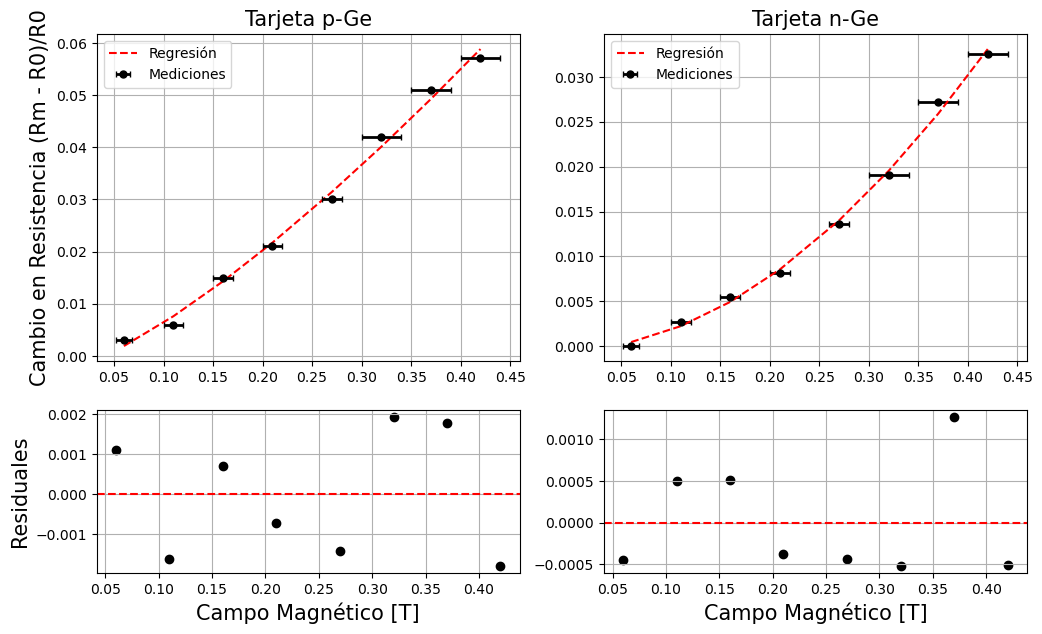

In [278]:
figure, axis = plt.subplots(2, 2, figsize = (12, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0, 0].plot(p_Mag_bfield[1::], power_law(p_Mag_bfield[1::], *p_MagCoeff), color='red', label = "Regresión", linestyle = "--")
axis[0, 0].errorbar(p_Mag_bfield[1::], p_MagRChange, xerr = p_Mag_bfieldUnc[1::], capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[1, 0].scatter(p_Mag_bfield[1::], pB3_RRes, color = "black")
axis[0, 0].legend()

axis[0, 1].errorbar(n_Mag_bfield[1::], n_MagRChange, xerr = n_Mag_bfieldUnc[1::], capsize=2, elinewidth=2, linewidth=0, marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0, 1].plot(n_Mag_bfield[1::], power_law(n_Mag_bfield[1::], *n_MagCoeff), color='red', label = "Regresión", linestyle = "--")
axis[1, 1].scatter(n_Mag_bfield[1::], nB3_RRes, color = "black")
axis[1, 1].set_xlabel('Campo Magnético [T]', fontsize = 15)
axis[1, 0].set_xlabel('Campo Magnético [T]', fontsize = 15)
axis[0, 0].set_ylabel('Cambio en Resistencia (Rm - R0)/R0', fontsize = 15)
axis[1, 0].set_ylabel('Residuales', fontsize = 15)
axis[0, 1].legend()

axis[1, 0].axhline(0, color = "red", linestyle = "--")
axis[1, 1].axhline(0, color = "red", linestyle = "--")
axis[0, 0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[0, 1].set_title("Tarjeta n-Ge", fontsize = 15)
axis[0, 1].grid(True)
axis[0, 0].grid(True)
axis[1, 1].grid(True)
axis[1, 0].grid(True)

plt.savefig("Resistance_Change.pdf")

> ## Actividad #4: Conductividad y Temperatura para tarjetas n-Ge, p-Ge e In-Ge:

En esta actividad buscamos determinar el comportamiento de la conductividad en función de la temperatura del sistema.

**Primera Medición:** Se establecerán los valores de $30$ mA para las tarjetas n-Ge y p-Ge, mientras que para la tarjeta In-Ge su valor debe ser de $5$ mA; mientras que se establecerá un valor de campo magnético nulo. Partiendo de estas referencias, la temperatura se incrementará, asegurandonos de que el valor no supere los $140°C$, y de manera simultánea se medirán los valores de voltaje longitudinal, para así calcular el valor de la conductividad.

Antes de desarrollar cualquier análisis, es preciso recordar qué son las regiones de conductividad intrínseca y extrínsecas:

**Conductividad Intrínseca:** Se produce cuando los electrones de un material son lo suficientemente excitados, en este caso mediante incrementos de temperatura, generando saltos más frecuentes de estos a la banda de conducción, incrementando su conductividad.

**Conductividad Extrínseca:** Se produce al dopar un material con átomos de otro elemento que trasmitan el incremento en la conductividad. Consideramos que esto no es posible dado que se está manipulando muestras puras.

Para estas tarjetas es necesario hacer una gráfica de conductividad en función del inverso de temperatura ($\sigma$ vs $\frac{1}{T}$). 

**Segunda Medición:** Posterior a estas medidas, **sólo para el caso de las tarjetas n-Ge y p-Ge**, se hará el mismo procedimiento con un campo magnético no nulo (~300mT). En estos casos particulares es posible combinar el procedimiento de las dos medidas simplemente midiendo el voltaje longitudinal a un campo magnético no nulo para el momento de elevar la temperatura, y retirar después el campo para medir los voltajes longitudinales al enfriar el sistema.

---

In [118]:
def Kelvin(Celsius):
    return Celsius + 273.15

Para poder manipular los datos de la **primera medición** de manera adecuada para así obtener los valores de la "Band Gap Energy". Recordemos que el comportamiento de estas placas en regiones de conuctividad intrínseca se puede modelar de la forma:

$$\sigma = \sigma_{0}e^{-E_{g}/k_{B}T}$$

Para poder obtener el valor de la energía de la banda de conducción es necesario aplicar una linealización de los datos (si se realiza con toda la muestra resulta evidente la región de conducción intrínseca), de esta manera:

$$\ln(\sigma) = \ln\left(\sigma_{0}e^{-E_{g}/k_{B}T}\right) = \ln\left(\sigma_{0}\right) + \ln\left(e^{-E_{g}/k_{B}T}\right) = -\frac{E_{g}}{k_{B}T} + \ln(\sigma_{0})$$

Así, al realizar una regresión de la relación $\sigma(1/T)$ se es posible obtener el valor de la energía de la banda de conducción sólo con la pendiente de esa regresión (conocemos la constante de Boltzmann). El valor a calcular como tal sería:

$$|m| = \frac{E_{g}}{k_{B}} \quad \Rightarrow \quad E_{g} = |m|k_{B}$$

---

> **n-Ge:**

En este apartado se mostrarán los resultados de la primera medición para la placa con portadores de carga negativos:

In [119]:
n_Temp = "n-Ge - Temp.xlsx"
nReg_Temp = pd.read_excel(path + n_Temp)
nReg_Temp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
T (1),25.000,30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.000
VL (B = 0),1.070,1.095,1.124,1.146,1.168,1.188,1.210,1.223,1.231,1.228,1.217,1.186,1.148,1.092,1.024,0.948
T (2),30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.000,105.000
VH (B = 1.41 A),-0.059,-0.058,-0.058,-0.057,-0.057,-0.056,-0.054,-0.052,-0.050,-0.047,-0.043,-0.039,-0.035,-0.030,-0.026,-0.022


In [228]:
n_GeTempC = nReg_Temp["T (1)"].to_numpy(dtype = float)
n_GeVL = nReg_Temp["VL (B = 0)"].to_numpy(dtype = float)
n_GeTempK = np.array([])

for i in n_GeTempC:
    n_GeTempK = np.append(n_GeTempK, Kelvin(i))

n_GeCond = np.array([])
n_GeCondUnc = []
n_GeRec = 1/n_GeTempK
n_GeRecUnc = []

for i in n_GeTempK:
    n_RecUnc = np.abs(1/i)*np.sqrt(1/(i**2))
    n_GeRecUnc.append(n_RecUnc)

for i in n_GeVL:
    cond = (10e-3*(0.030))/(i*(20e-3*1e-3))
    condunc = np.abs(cond)*np.abs(0.001/i)
    cond, condunc = Error(cond, condunc)
    n_GeCond = np.append(n_GeCond, cond)
    n_GeCondUnc.append(condunc)
    
n_GeCond = n_GeCond[::-1]
n_GeCondUnc = n_GeCondUnc[::-1]
n_GeRec = n_GeRec[::-1]
n_GeRecUnc = n_GeRecUnc[::-1]

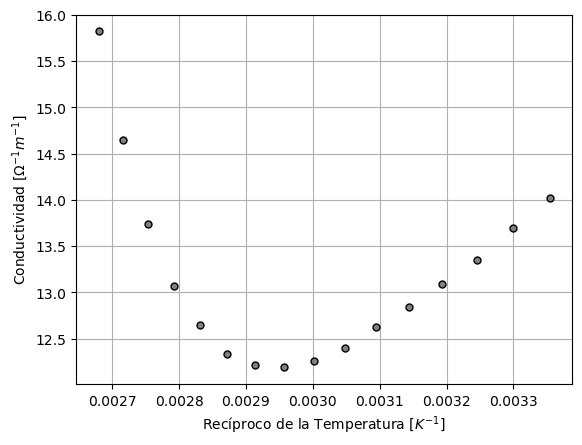

In [229]:
plt.errorbar(n_GeRec, n_GeCond, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Recíproco de la Temperatura $[K^{-1}]$")
plt.ylabel(r"Conductividad $[\Omega^{-1}m^{-1}]$")
plt.grid(True)

In [234]:
n_GeCondLN_ = np.log(n_GeCond)

#n_sigma0
n_GeLN_coeff, n_GeLN_cov = np.polyfit(n_GeRec[:5], n_GeCondLN_[:5], 1, cov = True)
n_GeLNUnc = np.sqrt(np.diag(n_GeLN_cov)) # Incertidumbre de los coeficientes.

n_GeRecReg = np.linspace(n_GeRec[0], n_GeRec[4], 100)
n_GeLNReg = n_GeLN_coeff[0]*n_GeRecReg + n_GeLN_coeff[1]

print(n_GeLN_coeff, n_GeLNUnc)

n_Ge_Eg = np.abs(n_GeLN_coeff[0])*Boltzmann*6.242e18
n_Ge_EgUnc = np.abs(n_Ge_Eg)*(n_GeLNUnc[0]/np.abs(n_GeLN_coeff[0]))

n_Ge_Eg, n_Ge_EgUnc = Error(n_Ge_Eg, n_Ge_EgUnc)

print(f"El valor obtenido para la energía de la banda de conducción es de {n_Ge_Eg} +/- {n_Ge_EgUnc} eV.")

n_GeRec_ = n_GeRec[:5]
n_GeCondLN_ = n_GeCondLN_[:5]

[-1475.54110766     6.6995147 ] [145.87277733   0.40191602]
El valor obtenido para la energía de la banda de conducción es de 0.13 +/- 0.01 eV.


In [212]:
n_GeLNRes = []

for i in range(0, len(n_GeCondLN_[:5])):
    Residue = n_GeCondLN_[i] - (n_GeLN_coeff[0]*n_GeRec_[i] + n_GeLN_coeff[1])
    n_GeLNRes.append(Residue)

Esta regresión generó un valor para la energía de la banda de conducción algo alejado de lo que se espera (más precisamente, un orden de magnitud menos). Por este motivo es mejor hacer una revisión mucho más profunda para verificar que se está analizando correctamente la muestra.

> **p-Ge:**

En este apartado se mostrarán los resultados de la primera medición para la placa con portadores de carga positivos:

In [150]:
p_Temp = "p-Ge - Temp.xlsx"
pReg_Temp = pd.read_excel(path + p_Temp)
pReg_Temp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
T (1),30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.00
VL (B = 0),1.024,1.061,1.098,1.131,1.164,1.199,1.236,1.265,1.293,1.311,1.323,1.323,1.301,1.268,1.21
T (2),30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.00
VH (B = 1.41 A),0.048,0.048,0.048,0.048,0.048,0.047,0.047,0.046,0.044,0.042,0.039,0.036,0.031,0.025,0.02


In [221]:
p_GeTempC = pReg_Temp["T (1)"].to_numpy(dtype = float)
p_GeVL = pReg_Temp["VL (B = 0)"].to_numpy(dtype = float)
p_GeTempK = np.array([])

for i in p_GeTempC:
    p_GeTempK = np.append(p_GeTempK, Kelvin(i))

p_GeCond = np.array([])
p_GeCondUnc = []
p_GeRec = 1/p_GeTempK
p_GeRecUnc = []

for i in p_GeTempK:
    p_RecUnc = np.abs(1/i)*np.sqrt(1/(i**2))
    p_GeRecUnc.append(p_RecUnc)

for i in p_GeVL:
    cond = (10e-3*(0.030))/(i*(20e-3*1e-3))
    condunc = np.abs(cond)*np.abs(0.001/i)
    cond, condunc = Error(cond, condunc)
    p_GeCond = np.append(p_GeCond, cond)
    p_GeCondUnc.append(condunc)
    
p_GeCond = p_GeCond[::-1]
p_GeCondUnc = p_GeCondUnc[::-1]
p_GeRec = p_GeRec[::-1]
p_GeRecUnc = p_GeRecUnc[::-1]

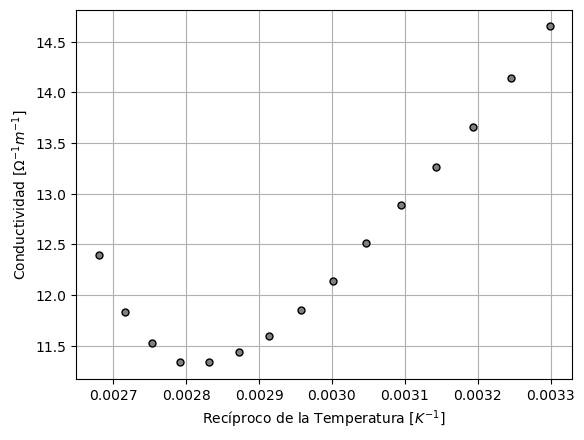

In [222]:
plt.errorbar(p_GeRec, p_GeCond, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Recíproco de la Temperatura $[K^{-1}]$")
plt.ylabel(r"Conductividad $[\Omega^{-1}m^{-1}]$")
plt.grid(True)

In [236]:
p_GeCondLN_ = np.log(p_GeCond)

p_GeLN_coeff, p_GeLN_cov = np.polyfit(p_GeRec[:4], p_GeCondLN_[:4], 1, cov = True)
p_GeLNUnc = np.sqrt(np.diag(p_GeLN_cov)) # Incertidumbre de los coeficientes.

print(p_GeLN_coeff, p_GeLNUnc)

# Grafica con el ajuste:
p_GeRecReg = np.linspace(p_GeRec[0], p_GeRec[3], 100)
p_GeLNReg = p_GeLN_coeff[0]*p_GeRecReg + p_GeLN_coeff[1]

p_Ge_Eg = np.abs(p_GeLN_coeff[0])*Boltzmann*6.242e18
p_Ge_EgUnc = np.abs(p_Ge_Eg)*(p_GeLNUnc[0]/np.abs(p_GeLN_coeff[0]))

p_Ge_Eg, p_Ge_EgUnc = Error(p_Ge_Eg, p_Ge_EgUnc)

print(f"El valor obtenido para la energía de la banda de conducción es de {p_Ge_Eg} +/- {p_Ge_EgUnc} eV.")

p_GeRec_ = p_GeRec[:4]
p_GeCondLN_ = p_GeCondLN_[:4]

[-784.31916403    4.61086316] [136.73343701   0.37407739]
El valor obtenido para la energía de la banda de conducción es de 0.07 +/- 0.01 eV.


In [216]:
p_GeLNRes = []

for i in range(0, len(p_GeCondLN_[:4])):
    Residue = p_GeCondLN_[i] - (p_GeLN_coeff[0]*p_GeRec_[i] + p_GeLN_coeff[1])
    p_GeLNRes.append(Residue)

Extrañamente el resultado obtenido para la energía de la banda de conducción es muy parecido al reportado por la literatura ($E_{g} = 0.66$ eV) salvo un orden de magnitud. Esto no es más que otra señal para pulir el análisis.

> **In-Ge:**

En este apartado se mostrarán los resultados de la primera (y única) medición para la placa con portadores de carga positivos y negativos en balance:

In [155]:
In_Temp = "In-Ge - Temp.xlsx"
InReg_Temp = pd.read_excel(path + In_Temp)
InReg_Temp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
T (1),25.00,30.00,35.00,40.00,45.00,50.00,55.00,60.00,65.00,70.00,75.00,80.00,85.0,90.00,95.00,100.0
VL (B = 0),4.21,3.69,3.15,2.63,2.18,1.85,1.49,1.22,1.03,0.84,0.71,0.59,0.5,0.42,0.36,0.3


In [224]:
In_GeTempC = InReg_Temp["T (1)"].to_numpy(dtype = float)
In_GeVL = InReg_Temp["VL (B = 0)"].to_numpy(dtype = float)
In_GeTempK = np.array([])

for i in In_GeTempC:
    In_GeTempK = np.append(In_GeTempK, Kelvin(i))

In_GeCond = np.array([])
In_GeRec = 1/In_GeTempK
In_GeRecUnc = []
In_GeCondUnc = []

for i in In_GeTempK:
    In_RecUnc = np.abs(1/i)*np.sqrt(1/(i**2))
    In_GeRecUnc.append(In_RecUnc)

for i in In_GeVL:
    cond = (20e-3*(0.030))/(i*(10e-3*1e-3))
    condunc = np.abs(cond)*np.abs(0.001/i)
    cond, condunc = Error(cond, condunc)
    In_GeCond = np.append(In_GeCond, cond)
    In_GeCondUnc.append(condunc)
    
In_GeCond = In_GeCond[::-1]
In_GeCondUnc = In_GeCondUnc[::-1]
In_GeRec = In_GeRec[::-1]
In_GeRecUnc = In_GeRecUnc[::-1]

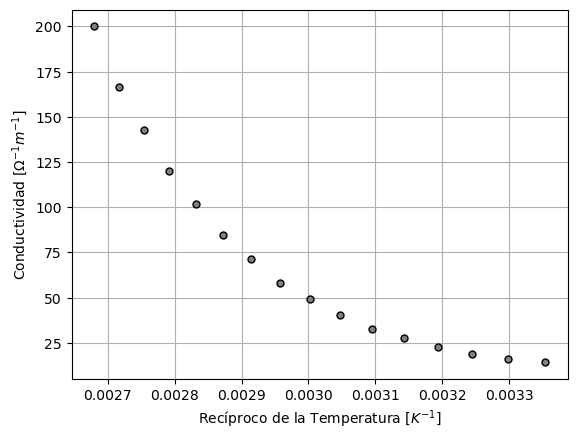

In [225]:
plt.errorbar(In_GeRec, In_GeCond, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Recíproco de la Temperatura $[K^{-1}]$")
plt.ylabel(r"Conductividad $[\Omega^{-1}m^{-1}]$")
plt.grid(True)

In [239]:
In_GeCondLN_ = np.log(In_GeCond)

In_GeLN_coeff, In_GeLN_cov = np.polyfit(In_GeRec, In_GeCondLN_, 1, cov = True)
In_GeLNUnc = np.sqrt(np.diag(In_GeLN_cov)) # Incertidumbre de los coeficientes.

In_GeRecReg = np.linspace(In_GeRec[0], In_GeRec[-1], 100)
In_GeLNReg = In_GeLN_coeff[0]*In_GeRecReg + In_GeLN_coeff[1]

print(In_GeLN_coeff, In_GeLNUnc)

In_Ge_Eg = np.abs(In_GeLN_coeff[0])*Boltzmann*6.242e18
In_Ge_EgUnc = np.abs(In_Ge_Eg)*(In_GeLNUnc[0]/np.abs(In_GeLN_coeff[0]))

In_Ge_Eg, In_Ge_EgUnc = Error(In_Ge_Eg, In_Ge_EgUnc)

print(f"De manera preliminar, el valor obtenido para la energía de la banda de conducción es de {In_Ge_Eg} +/- {In_Ge_EgUnc} eV.")

[-4020.5126731     16.00159296] [70.08290731  0.21029019]
De manera preliminar, el valor obtenido para la energía de la banda de conducción es de 0.346 +/- 0.006 eV.


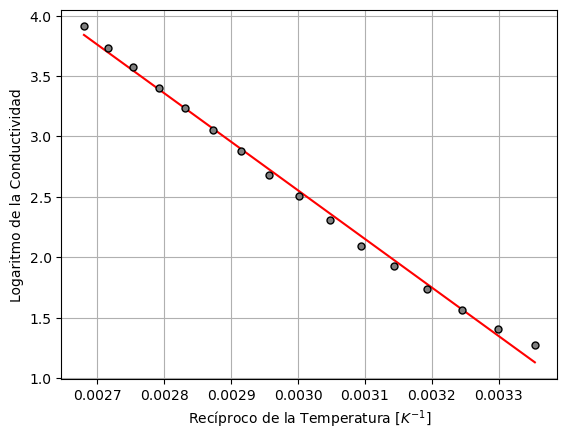

In [159]:
plt.errorbar(In_GeRec, In_GeCondLN_, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.plot(In_GeRecReg, In_GeLNReg, color = "red")
plt.xlabel(r"Recíproco de la Temperatura $[K^{-1}]$")
plt.ylabel(r"Logaritmo de la Conductividad")
plt.grid(True)

In [160]:
In_GeLNRes = []

for i in range(0, len(In_GeCondLN_)):
    Residue = In_GeCondLN_[i] - (In_GeLN_coeff[0]*In_GeRec[i] + In_GeLN_coeff[1])
    In_GeLNRes.append(Residue)

Este valor de la energía de la banda de conducción es ciertamente cercano en cuanto a orden de magnitud, pero muy seguramente tenga sus falencias en cuanto a la búsqueda de este valor propiamente dicho. Queda también como objeto de revisión.

---

Para la **segunda medición** se debe de hallar el coeficiente de Hall para las muestras de n-Ge y p-Ge. Posteriormente se realizará una gráfica del coeficiente de Hall en función de la temperatura y se debe de analizar su comportamiento.

Luego se establecerá una regresión de la forma $\ln\left(R_{H}T^{3/2}\right)$ en función $1/T$. El motivo de esta regresión no es otro que el partir de una linealización de la expresión que determina la cantidad de huecos en un conductor intrínseco:

$$n_{h} = 2\left(\frac{k_{B}T}{2\pi\hbar^{2}}\right)^{3/2}(m_{e}m_{h})^{3/4}e^{-E_{g}/2k_{B}T}$$

Expresión que podemos resumir al agrupar todas las constantes en un valor $\alpha$ tal que:

$$n_{h} = \alpha T^{3/2}e^{-E_{g}/2k_{B}T} \quad \Rightarrow \quad \alpha = 2\left(\frac{k_{B}}{2\pi\hbar^{2}}\right)^{3/2}(m_{e}m_{h})^{3/4}$$

Si multiplicamos por la carga del electrón por ambos lados, nos queda el inverso del coeficiente de Hall ($\beta = e\alpha$):

$$n_{h}e = \beta T^{3/2}e^{-E_{g}/2k_{B}T} = \frac{1}{R_{H}}$$

Despejando y aplicando logaritmo natural en ambos lados:

$$\beta T^{3/2}R_{H} = e^{E_{g}/2k_{B}T}$$

$$\ln(\beta) + \ln\left(T^{3/2}R_{H}\right) = \frac{E_{g}}{2k_{B}T}$$

$$\ln\left(T^{3/2}R_{H}\right) = \frac{E_{g}}{2k_{B}T} - \ln(\beta)$$

Por tanto, la pendiente de la regresión se relaciona con la energía de la banda de conducción de la siguiente manera:

$$m = \frac{E_{g}}{2k_{B}} \quad \Rightarrow \quad E_{g} = 2k_{B}m$$

Siendo este el procedimiento que se debe seguir.

---

> **n-Ge:**

Esta será la parte de análisis neta para la placa con portadores de carga negativos:

In [161]:
n_Temp = "n-Ge - Temp.xlsx"
nReg_Temp = pd.read_excel(path + n_Temp)
nReg_Temp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
T (1),25.000,30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.000
VL (B = 0),1.070,1.095,1.124,1.146,1.168,1.188,1.210,1.223,1.231,1.228,1.217,1.186,1.148,1.092,1.024,0.948
T (2),30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.000,105.000
VH (B = 1.41 A),-0.059,-0.058,-0.058,-0.057,-0.057,-0.056,-0.054,-0.052,-0.050,-0.047,-0.043,-0.039,-0.035,-0.030,-0.026,-0.022


0.3 0.02


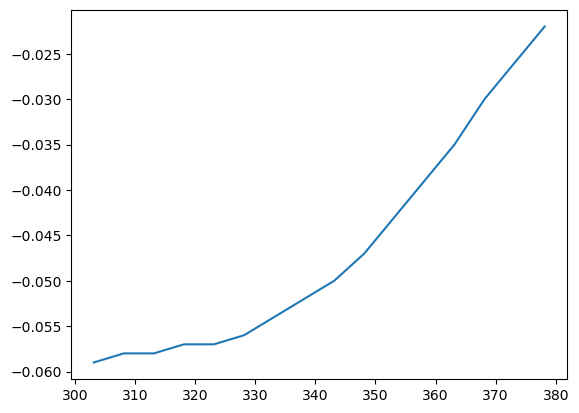

In [240]:
n_GeTempC = nReg_Temp["T (2)"].to_numpy(dtype = float)
n_GeVH = nReg_Temp["VH (B = 1.41 A)"].to_numpy(dtype = float)
n_GeTempK = np.array([])

for i in n_GeTempC:
    n_GeTempK = np.append(n_GeTempK, Kelvin(i))

n_Ge_MagField, n_Ge_MagFieldUnc = Magnetic_Field(1.41)
n_Ge_MagRHRec = 1/n_GeTempK
n_Ge_MagRH = np.array([])

print(n_Ge_MagField, n_Ge_MagFieldUnc)

for i in n_GeVH:
    RH = i*1e-3/(0.030*n_Ge_MagField)
    n_Ge_MagRH = np.append(n_Ge_MagRH, RH)

n_Ge_MagLNRH = np.log(np.abs(n_GeTempK**(3/2) * n_Ge_MagRH))
n_Ge_MagRHRec = n_Ge_MagRHRec[::-1]
n_Ge_MagLNRH = n_Ge_MagLNRH[::-1]
plt.plot(n_GeTempK, n_GeVH)

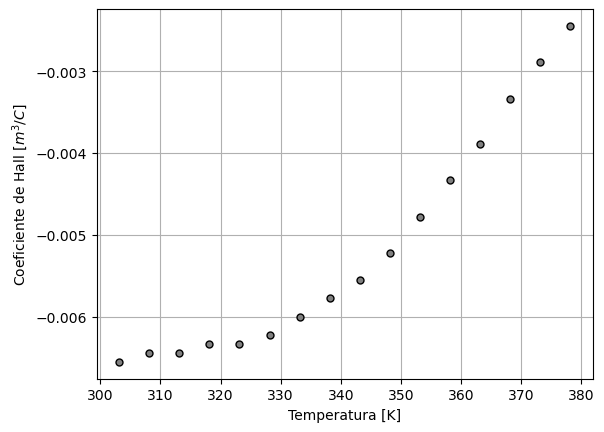

In [163]:
plt.errorbar(n_GeTempK, n_Ge_MagRH, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel("Temperatura [K]")
plt.ylabel(r"Coeficiente de Hall $[m^3/C]$")
plt.grid(True)

La gráfica asociada al sistema con la nueva parametrización será:

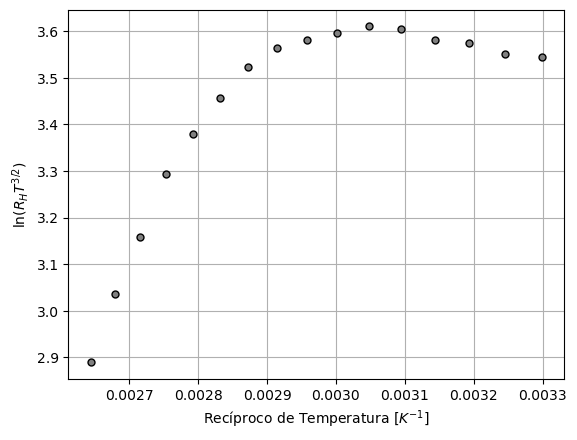

In [164]:
plt.errorbar(n_Ge_MagRHRec, n_Ge_MagLNRH, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Recíproco de Temperatura [$K^{-1}$]")
plt.ylabel(r"$\ln(R_{H}T^{3/2})$")
plt.grid(True)

Analizando la función en la región intrínseca se obtiene:

In [259]:
n_GeLNRH_coeff, n_GeLNRH_cov = np.polyfit(n_Ge_MagRHRec[:7], n_Ge_MagLNRH[:7], 1, cov = True)
n_GeLNRHUnc = np.sqrt(np.diag(n_GeLNRH_cov)) # Incertidumbre de los coeficientes.

# Grafica con el ajuste:
n_GeLNRHRecReg = np.linspace(n_Ge_MagRHRec[0], n_Ge_MagRHRec[6], 100)
n_GeLNRHReg = n_GeLNRH_coeff[0]*n_GeLNRHRecReg + n_GeLNRH_coeff[1]

n_Ge_LNRHEg = 2*np.abs(n_GeLNRH_coeff[0])*Boltzmann*6.242e18
n_Ge_LNRHEgUnc = np.abs(n_Ge_LNRHEg)*(n_GeLNRHUnc[0]/n_GeLNRH_coeff[0])

n_Ge_LNRHEg, n_Ge_LNRHEgUnc = Error(n_Ge_LNRHEg, n_Ge_LNRHEgUnc)

print(f"El valor obtenido para la energía de la banda de conducción es de {n_Ge_LNRHEg} +/- {n_Ge_LNRHEgUnc} eV.")

El valor obtenido para la energía de la banda de conducción es de 0.48 +/- 0.04 eV.


In [260]:
n_GeLNRHRes = []

for i in range(0, len(n_Ge_MagRHRec[:7])):
    Residue = n_Ge_MagLNRH[i] - (n_GeLNRH_coeff[0]*n_Ge_MagRHRec[:7][i] + n_GeLNRH_coeff[1])
    n_GeLNRHRes.append(Residue)

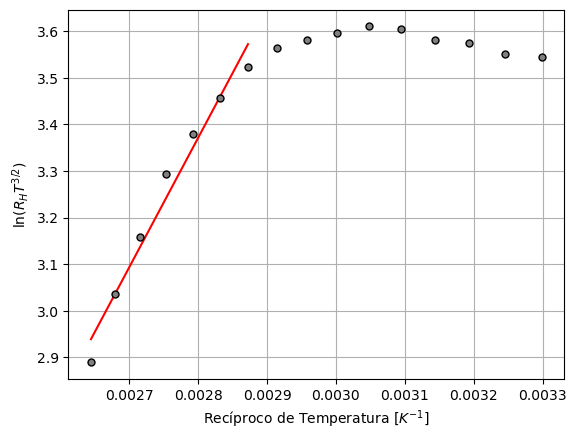

In [261]:
plt.plot(n_GeLNRHRecReg, n_GeLNRHReg, color = "red")
plt.errorbar(n_Ge_MagRHRec, n_Ge_MagLNRH, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='0.5', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.xlabel(r"Recíproco de Temperatura [$K^{-1}$]")
plt.ylabel(r"$\ln(R_{H}T^{3/2})$")
plt.grid(True)

Los resultados obtenidos aquí resultan mucho más esperanzadores que su análogo en la primera medición. El orden de magnitud y su valor son próximos al esperado de alrededor de 0.66 eV.

> **n-Ge:**

Esta será la parte de análisis neta para la placa con portadores de carga negativos:

In [168]:
p_Temp = "p-Ge - Temp.xlsx"
nReg_Temp = pd.read_excel(path + n_Temp)
nReg_Temp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
T (1),25.000,30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.000
VL (B = 0),1.070,1.095,1.124,1.146,1.168,1.188,1.210,1.223,1.231,1.228,1.217,1.186,1.148,1.092,1.024,0.948
T (2),30.000,35.000,40.000,45.000,50.000,55.000,60.000,65.000,70.000,75.000,80.000,85.000,90.000,95.000,100.000,105.000
VH (B = 1.41 A),-0.059,-0.058,-0.058,-0.057,-0.057,-0.056,-0.054,-0.052,-0.050,-0.047,-0.043,-0.039,-0.035,-0.030,-0.026,-0.022


In [169]:
p_GeTempC = pReg_Temp["T (2)"].to_numpy(dtype = float)
p_GeVH = pReg_Temp["VH (B = 1.41 A)"].to_numpy(dtype = float)
p_GeTempK = np.array([])

for i in p_GeTempC:
    p_GeTempK = np.append(p_GeTempK, Kelvin(i))

p_Ge_MagField, p_Ge_MagFieldUnc = Magnetic_Field(1.41)
p_Ge_MagRHRec = 1/p_GeTempK
p_Ge_MagRH = np.array([])

for i in p_GeVH:
    RH = i*1e-3/(0.030*p_Ge_MagField)
    p_Ge_MagRH = np.append(p_Ge_MagRH, RH)

p_Ge_MagLNRH = np.log(np.abs(p_GeTempK**(3/2) * p_Ge_MagRH))
p_Ge_MagRHRec = p_Ge_MagRHRec[::-1]
p_Ge_MagLNRH = p_Ge_MagLNRH[::-1]

Analizando la función en la región intrínseca se obtiene:

In [170]:
p_GeLNRH_coeff, p_GeLNRH_cov = np.polyfit(p_Ge_MagRHRec[:5], p_Ge_MagLNRH[:5], 1, cov = True)
p_GeLNRHUnc = np.sqrt(np.diag(p_GeLNRH_cov)) # Incertidumbre de los coeficientes.

# Grafica con el ajuste:
p_GeLNRHRecReg = np.linspace(p_Ge_MagRHRec[0], p_Ge_MagRHRec[4], 100)
p_GeLNRHReg = p_GeLNRH_coeff[0]*p_GeLNRHRecReg + p_GeLNRH_coeff[1]

p_Ge_LNRHEg = 2*np.abs(p_GeLNRH_coeff[0])*Boltzmann*6.242e18
p_Ge_LNRHEgUnc = np.abs(p_Ge_LNRHEg)*(p_GeLNRHUnc[0]/p_GeLNRH_coeff[0])

p_Ge_LNRHEg, p_Ge_LNRHEgUnc = Error(p_Ge_LNRHEg, p_Ge_LNRHEgUnc)

print(f"El valor obtenido para la energía de la banda de conducción es de {p_Ge_LNRHEg} +/- {p_Ge_LNRHEgUnc} eV.")

El valor obtenido para la energía de la banda de conducción es de 0.68 +/- 0.09 eV.


In [171]:
p_GeLNRHRes = []

for i in range(0, len(p_Ge_MagRHRec[:5])):
    Residue = p_Ge_MagLNRH[i] - (p_GeLNRH_coeff[0]*p_Ge_MagRHRec[:5][i] + p_GeLNRH_coeff[1])
    p_GeLNRHRes.append(Residue)

De todos los resultados para el valor de la banda de conducción, éste resulta ser el más próximo al esperado. Por tanto se puede observar una cierta inclinción a "buenos resultados" de parte de la tarjeta p-Ge. ¿Quizá la tarjeta n-Ge tenga algún defecto?
Puede ser una buena hipótesis, pero solo cuando se halla pulido el análisis se podrá determinar algo así.

> ## Gráficas Generales - Actividad #4:

**Primera medición:** En esta sección se muestra la gráfica asociada al primer de los apartados de la actividad relacionada con la medición del voltaje de Hall para las placas de n-Ge, p-Ge y In-Ge:

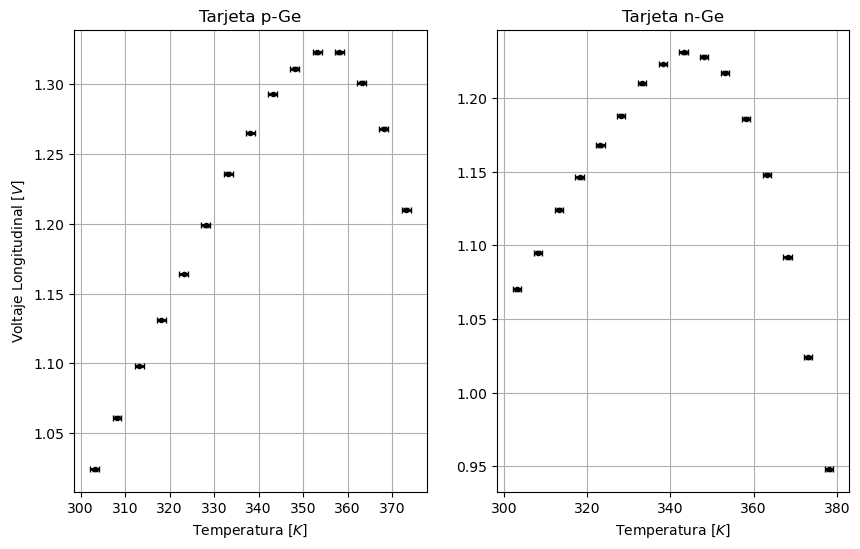

In [263]:
figure, axis = plt.subplots(1, 2, figsize = (10, 6))

axis[1].errorbar(n_GeTempK, n_GeVL, yerr = 0.001, xerr = 1, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=3, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0].errorbar(p_GeTempK, p_GeVL, yerr = 0.001, xerr = 1, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=3, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')

axis[0].set_title("Tarjeta p-Ge")
axis[1].set_title("Tarjeta n-Ge")
axis[0].set_xlabel(r"Temperatura $[K]$")
axis[1].set_xlabel(r"Temperatura $[K]$")
axis[0].set_ylabel(r"Voltaje Longitudinal $[V]$")

axis[1].grid(True)
axis[0].grid(True)

plt.savefig("Thermic_DataNG.pdf")

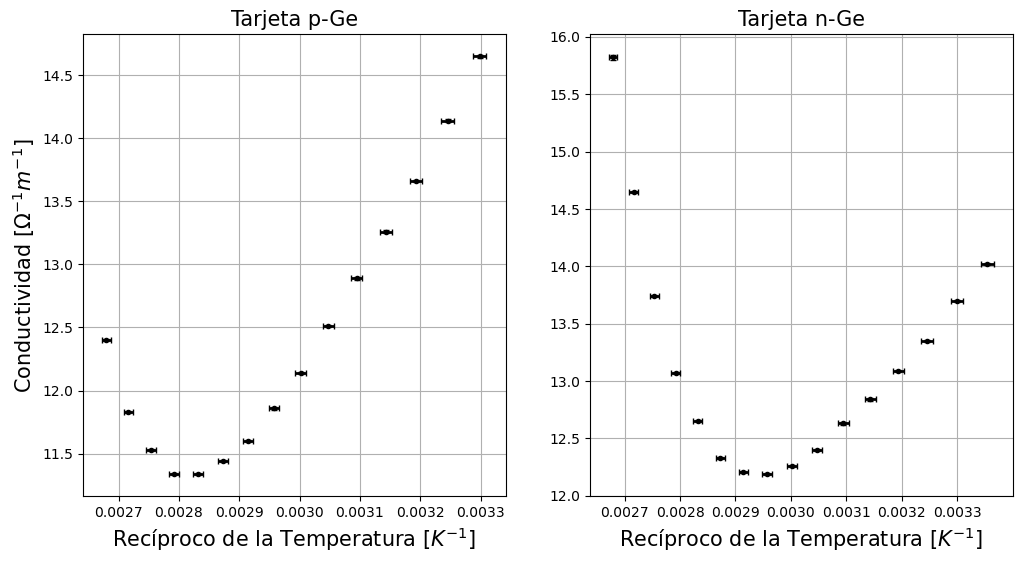

In [272]:
figure, axis = plt.subplots(1, 2, figsize = (12, 6))

axis[1].errorbar(n_GeRec, n_GeCond, xerr = n_GeRecUnc, yerr = n_GeCondUnc, capsize=2,elinewidth=2, linewidth=0,
             marker='o', markersize=3,markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0].errorbar(p_GeRec, p_GeCond, xerr = p_GeRecUnc, yerr = p_GeCondUnc, capsize=2,elinewidth=2, linewidth=0,
             marker='o', markersize=3,markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')

axis[0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[1].set_title("Tarjeta n-Ge", fontsize = 15)
axis[0].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[1].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[0].set_ylabel(r"Conductividad $[\Omega^{-1}m^{-1}]$", fontsize = 15)

axis[1].grid(True)
axis[0].grid(True)

plt.savefig("Thermic_ConductivityNG.pdf")

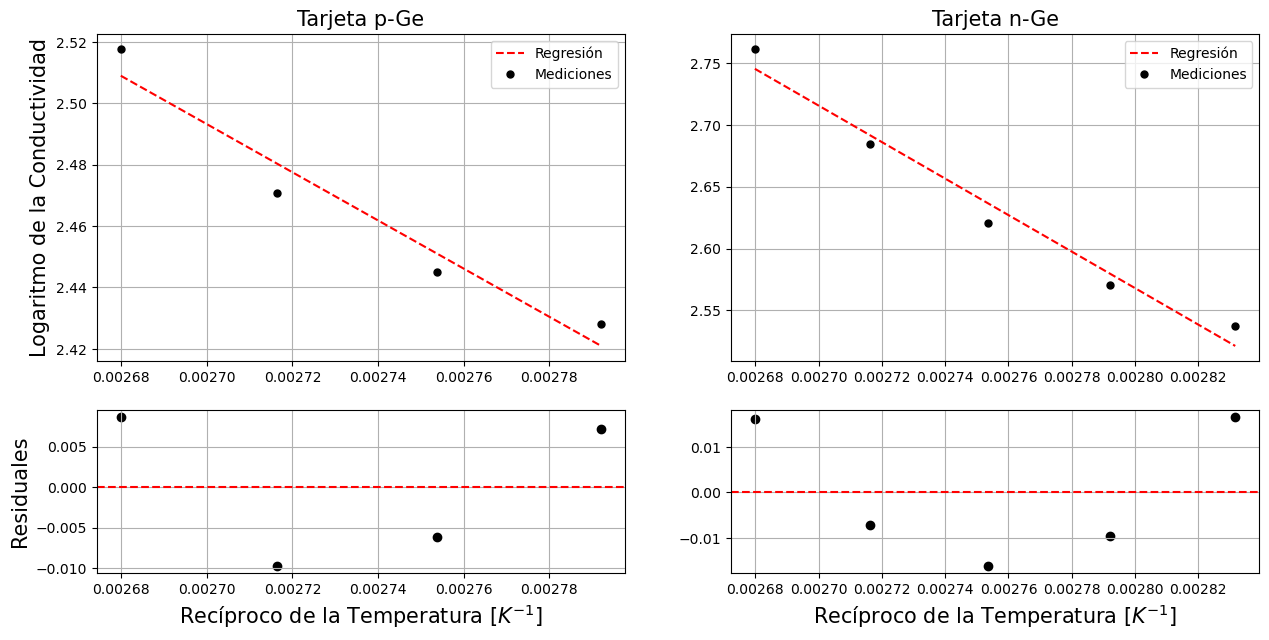

In [273]:
figure, axis = plt.subplots(2, 2, figsize = (15, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0, 0].errorbar(p_GeRec_, p_GeCondLN_, capsize=5, elinewidth=2, linewidth=0, marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0, 1].errorbar(n_GeRec_, n_GeCondLN_, capsize=5, elinewidth=2, linewidth=0, marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[1, 0].scatter(p_GeRec[:4], p_GeLNRes, color = "black")
axis[1, 1].scatter(n_GeRec[:5], n_GeLNRes, color = "black")
axis[0, 1].plot(n_GeRecReg, n_GeLNReg, color = "red", linestyle = "--", label = "Regresión")
axis[0, 0].plot(p_GeRecReg, p_GeLNReg, color = "red", linestyle = "--", label = "Regresión")
axis[1, 1].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[1, 0].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[0, 0].set_ylabel(r"Logaritmo de la Conductividad", fontsize = 15)
axis[1, 0].set_ylabel(r"Residuales", fontsize = 15)
axis[0, 0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[0, 1].set_title("Tarjeta n-Ge", fontsize = 15)

axis[1, 0].axhline(0, color = "red", linestyle = "--")
axis[1, 1].axhline(0, color = "red", linestyle = "--")
axis[0, 1].legend()
axis[0, 0].legend()
axis[0, 0].grid(True)
axis[0, 1].grid(True)
axis[1, 0].grid(True)
axis[1, 1].grid(True)
plt.savefig("ThermicLogNG.pdf")

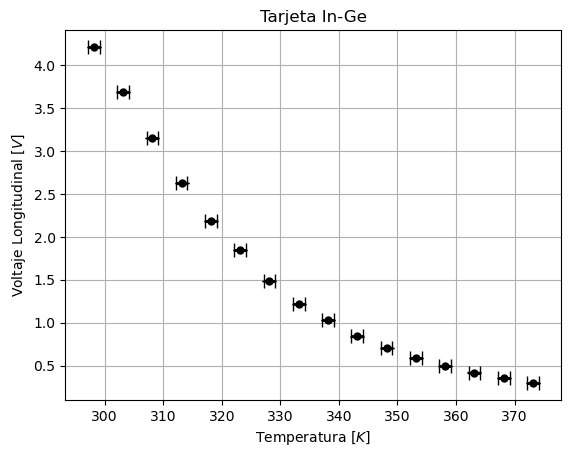

In [184]:
plt.errorbar(In_GeTempK, In_GeVL, yerr = 0.001, xerr = 1, capsize=5, elinewidth=2, linewidth=0, marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.grid(True)
plt.xlabel(r"Temperatura $[K]$")
plt.ylabel(r"Voltaje Longitudinal $[V]$")
plt.title("Tarjeta In-Ge")
plt.savefig("Thermic_DataIn.pdf")

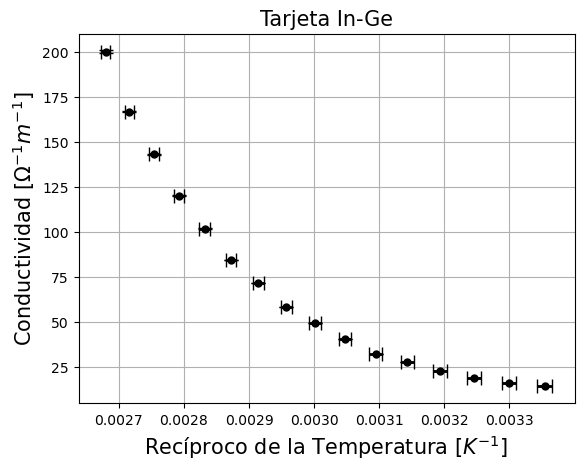

In [274]:
plt.errorbar(In_GeRec, In_GeCond, xerr = In_GeRecUnc, yerr = In_GeCondUnc, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
plt.grid(True)
plt.xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
plt.ylabel(r"Conductividad $[\Omega^{-1}m^{-1}]$", fontsize = 15)
plt.title("Tarjeta In-Ge", fontsize = 15)
plt.savefig("Thermic_ConductivityIn.pdf")

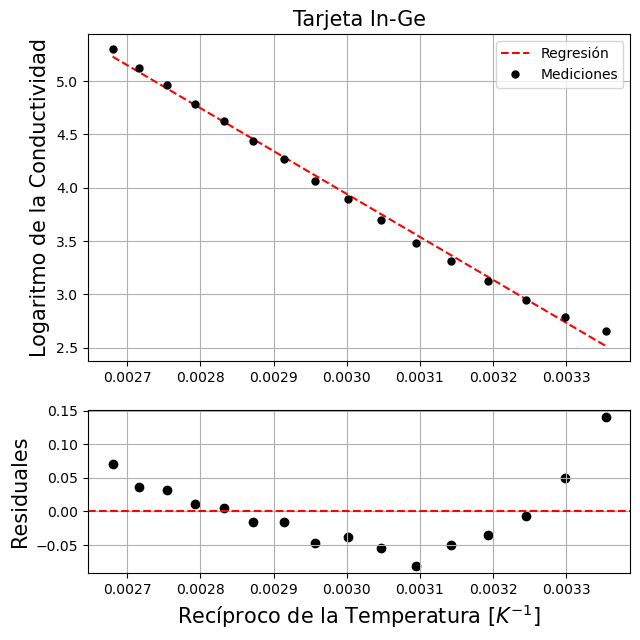

In [275]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0].errorbar(In_GeRec, In_GeCondLN_, capsize=5, elinewidth=2, linewidth=0, marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0].plot(In_GeRecReg, In_GeLNReg, color = "red", linestyle = "--", label = "Regresión")
axis[0].legend()
axis[0].set_ylabel("Logaritmo de la Conductividad", fontsize = 15)
axis[1].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[1].set_ylabel("Residuales", fontsize = 15)
axis[1].axhline(0, color = "red", linestyle = "--")
axis[1].scatter(In_GeRec, In_GeLNRes, color = "black")
axis[0].set_title("Tarjeta In-Ge", fontsize = 15)

axis[0].grid(True)
axis[1].grid(True)
plt.savefig("ThermicLogIn.pdf")

**Segunda medición:** Aquí se presenta el conjunto de gráficas que representan los cálculos realizados sobre la segunda medición:

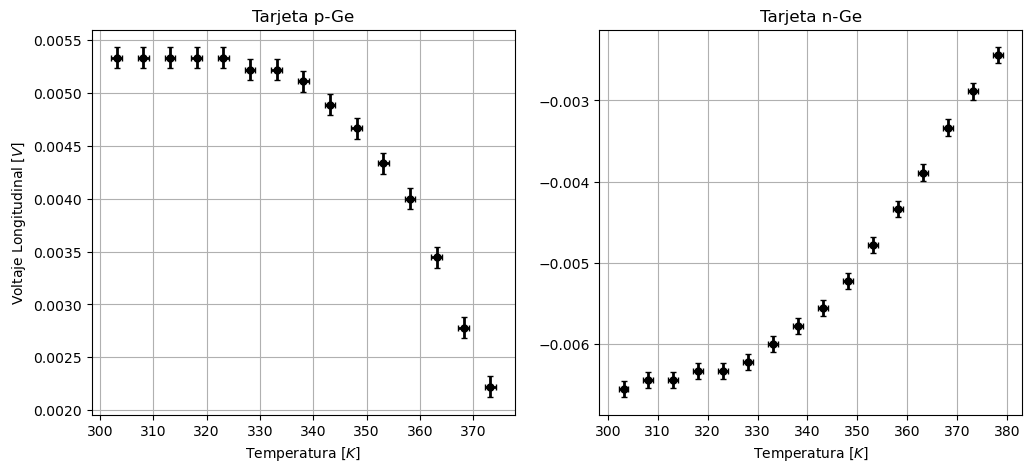

In [192]:
figure, axis = plt.subplots(1, 2, figsize = (12, 5))

axis[1].errorbar(n_GeTempK, n_Ge_MagRH, yerr = 0.0001, xerr = 1, capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0].errorbar(p_GeTempK, p_Ge_MagRH, yerr = 0.0001, xerr = 1,capsize=2, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')

axis[0].set_title("Tarjeta p-Ge")
axis[1].set_title("Tarjeta n-Ge")
axis[0].set_xlabel(r"Temperatura $[K]$")
axis[1].set_xlabel(r"Temperatura $[K]$")
axis[0].set_ylabel(r"Voltaje Longitudinal $[V]$")

axis[1].grid(True)
axis[0].grid(True)
plt.savefig("Thermic_BDataNG.pdf")

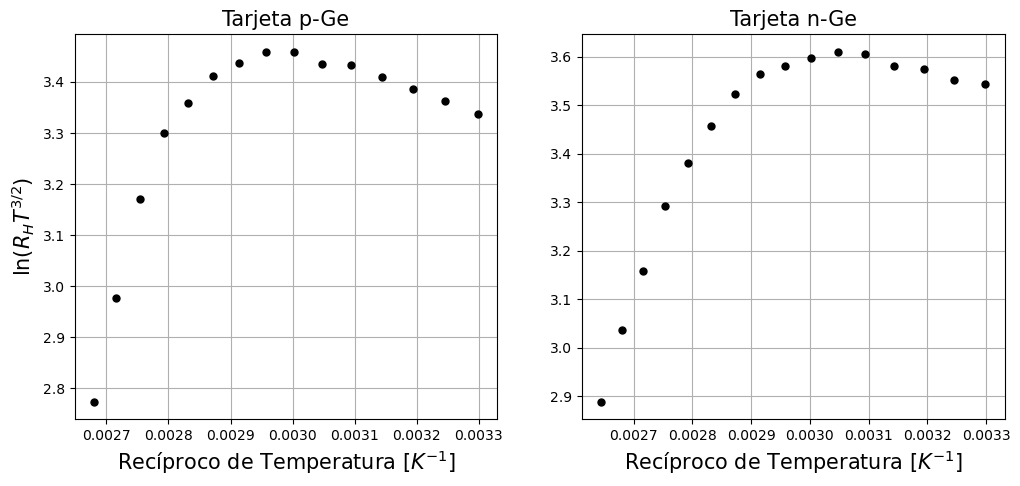

In [276]:
figure, axis = plt.subplots(1, 2, figsize = (12, 5))

axis[1].errorbar(n_Ge_MagRHRec, n_Ge_MagLNRH, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0].errorbar(p_Ge_MagRHRec, p_Ge_MagLNRH, capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')

axis[0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[1].set_title("Tarjeta n-Ge", fontsize = 15)
axis[0].set_xlabel(r"Recíproco de Temperatura [$K^{-1}$]", fontsize = 15)
axis[1].set_xlabel(r"Recíproco de Temperatura [$K^{-1}$]", fontsize = 15)
axis[0].set_ylabel(r"$\ln(R_{H}T^{3/2})$", fontsize = 15)

axis[1].grid(True)
axis[0].grid(True)
plt.savefig("Thermic_BLogNG.pdf")

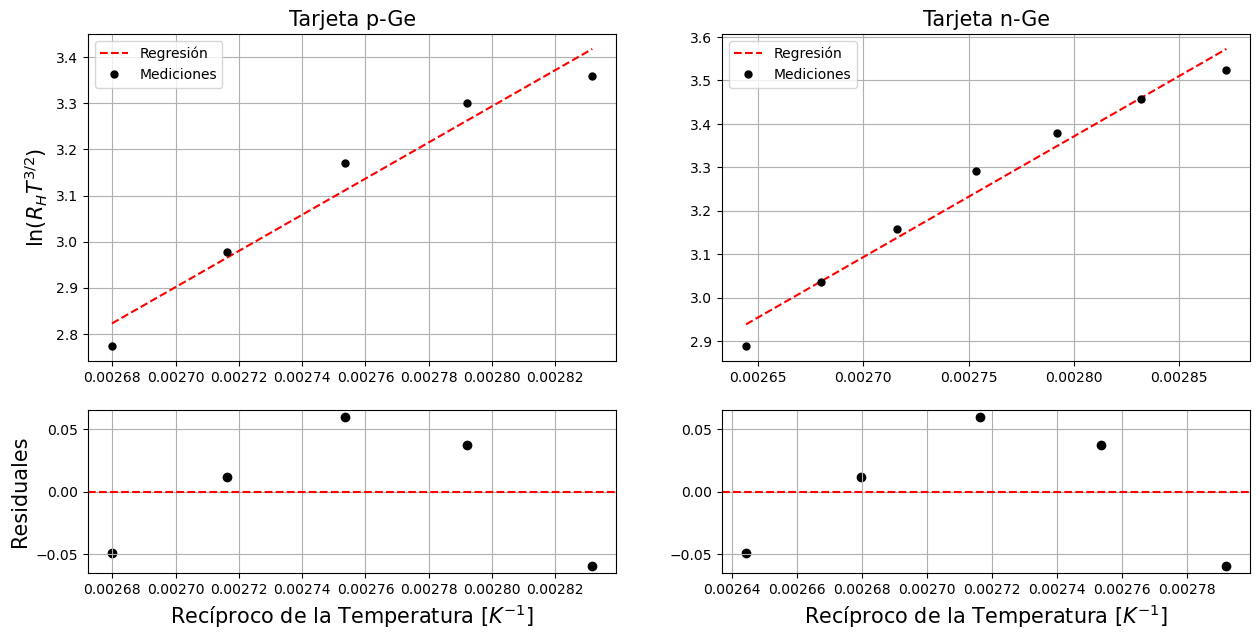

In [277]:
figure, axis = plt.subplots(2, 2, figsize = (15, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0, 0].errorbar(p_Ge_MagRHRec[:5], p_Ge_MagLNRH[:5], capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')
axis[0, 1].errorbar(n_Ge_MagRHRec[:7], n_Ge_MagLNRH[:7], capsize=5, elinewidth=2, linewidth=0,
             marker='o', markersize=5, markerfacecolor='black', markeredgecolor='k',ecolor='k', label='Mediciones')

axis[1, 0].scatter(p_Ge_MagRHRec[:5], p_GeLNRHRes, color = "black")
axis[1, 1].scatter(n_Ge_MagRHRec[:5], p_GeLNRHRes, color = "black")
axis[0, 1].plot(n_GeLNRHRecReg, n_GeLNRHReg, color = "red", linestyle = "--", label = "Regresión")
axis[0, 0].plot(p_GeLNRHRecReg, p_GeLNRHReg, color = "red", linestyle = "--", label = "Regresión")
axis[1, 1].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[1, 0].set_xlabel(r"Recíproco de la Temperatura $[K^{-1}]$", fontsize = 15)
axis[0, 0].set_ylabel(r"$\ln(R_{H}T^{3/2})$", fontsize = 15)
axis[1, 0].set_ylabel(r"Residuales", fontsize = 15)
axis[0, 0].set_title("Tarjeta p-Ge", fontsize = 15)
axis[0, 1].set_title("Tarjeta n-Ge", fontsize = 15)

axis[1, 0].axhline(0, color = "red", linestyle = "--")
axis[1, 1].axhline(0, color = "red", linestyle = "--")
axis[0, 1].legend()
axis[0, 0].legend()

axis[0, 0].grid(True)
axis[0, 1].grid(True)
axis[1, 0].grid(True)
axis[1, 1].grid(True)

plt.savefig("Thermic_BNG.pdf")